In [2]:
import pandas as pd
import numpy as np
from scipy import stats, signal
from tqdm import trange, tqdm
from matplotlib.pyplot import *

%matplotlib inline

In [3]:
# figure styling
import seaborn as sns
sns.set(style='ticks', palette='colorblind')

rcParams['figure.figsize'] = (13,4.5)
rcParams['figure.dpi'] = 200

In [4]:
images = np.load('../data/stim.npy')

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/sub.csv')

dd = np.load('../data/features.npz')
features = dict()
for k in dd.keys():
    features[k] = dd[k]

    
conv_train = np.load('../data/conv_train.npy').flat[0]
conv_test = np.load('../data/conv_test.npy').flat[0]

conv_features = dict()
for k in conv_train.keys():
    conv_features[k] = np.vstack([conv_test[k], conv_train[k]])

In [5]:
vgg_features = dict()
for i in range(5,10):
    print(i)
    fname = '../data/vgg_conv{}.npz'.format(i)
    d = np.load(fname)
    arr = d['arr_0'].reshape(images.shape[0], -1)
    stds = np.std(arr, axis=0)
    vgg_features['vgg'+str(i)] = arr[:, stds > 0]

5
6
7
8
9


In [6]:
features.keys()

dict_keys(['raw', 'LAB', 'fourier', 'gabor', 'stats', 'stats_LAB', 'stats_HSV', 'stats_edges'])

In [7]:
conv_features.keys()

dict_keys(['conv1', 'conv2', 'conv3', 'conv4', 'conv5'])

In [8]:
vgg_features.keys()

dict_keys(['vgg5', 'vgg6', 'vgg7', 'vgg8', 'vgg9'])

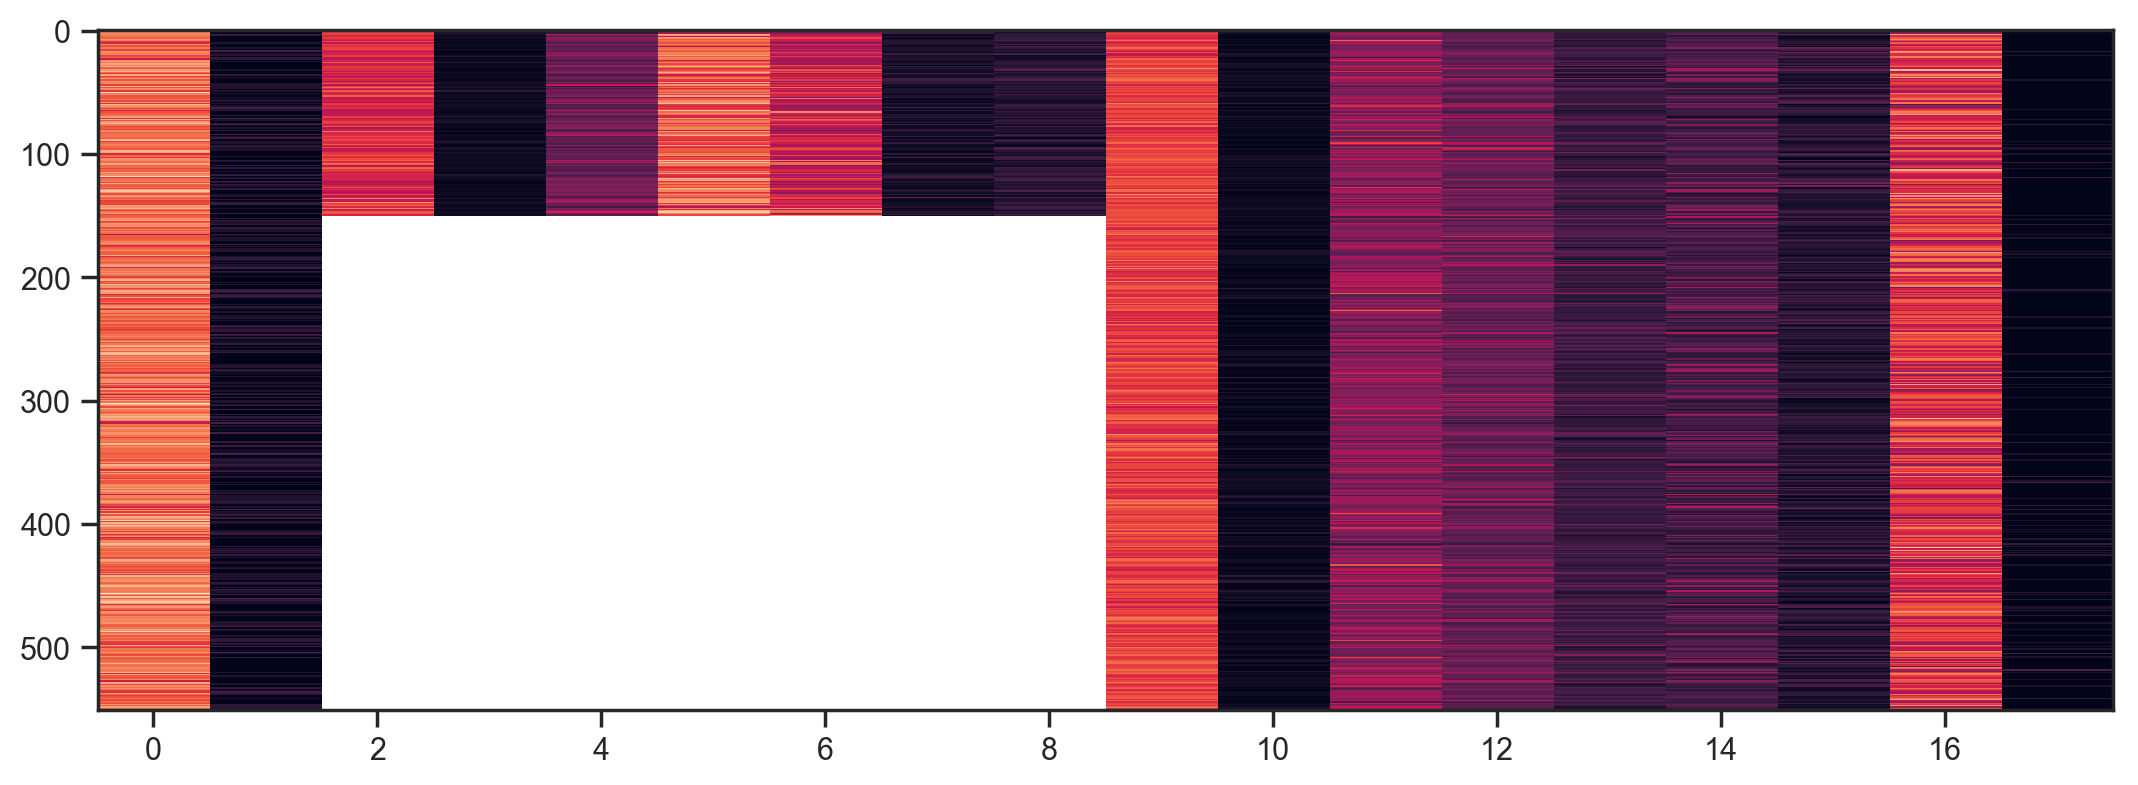

In [9]:
responses = np.array(train.iloc[:, 1:])

imshow(responses, aspect='auto')

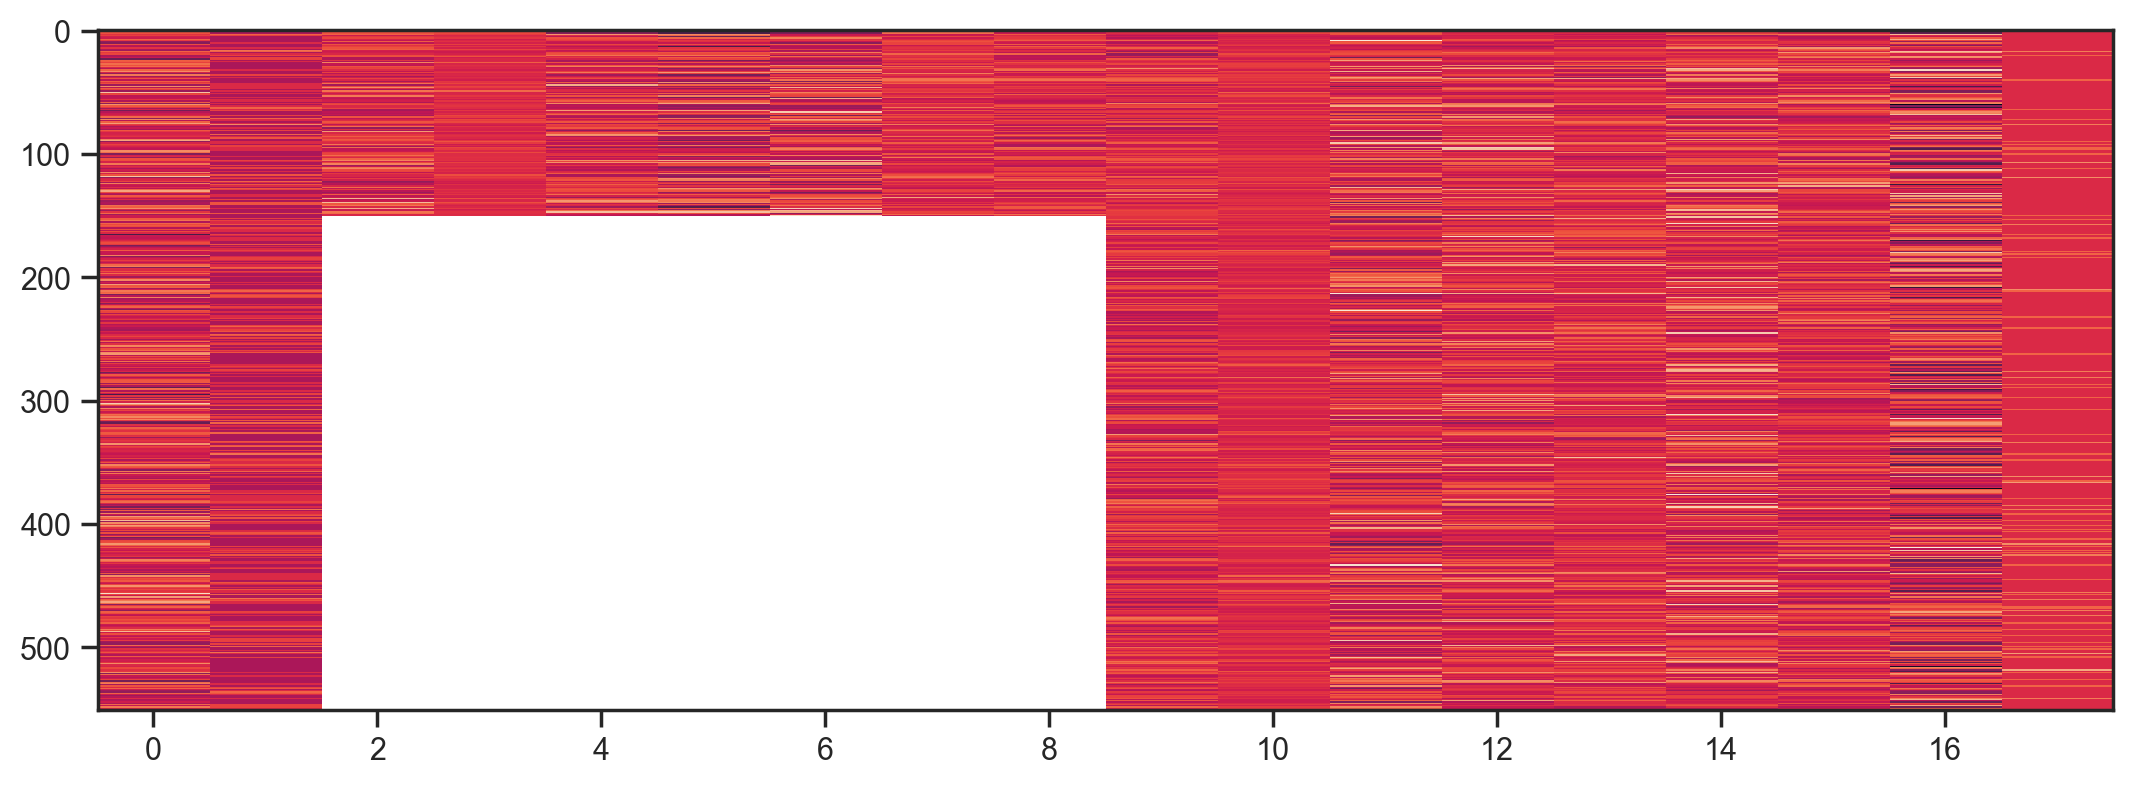

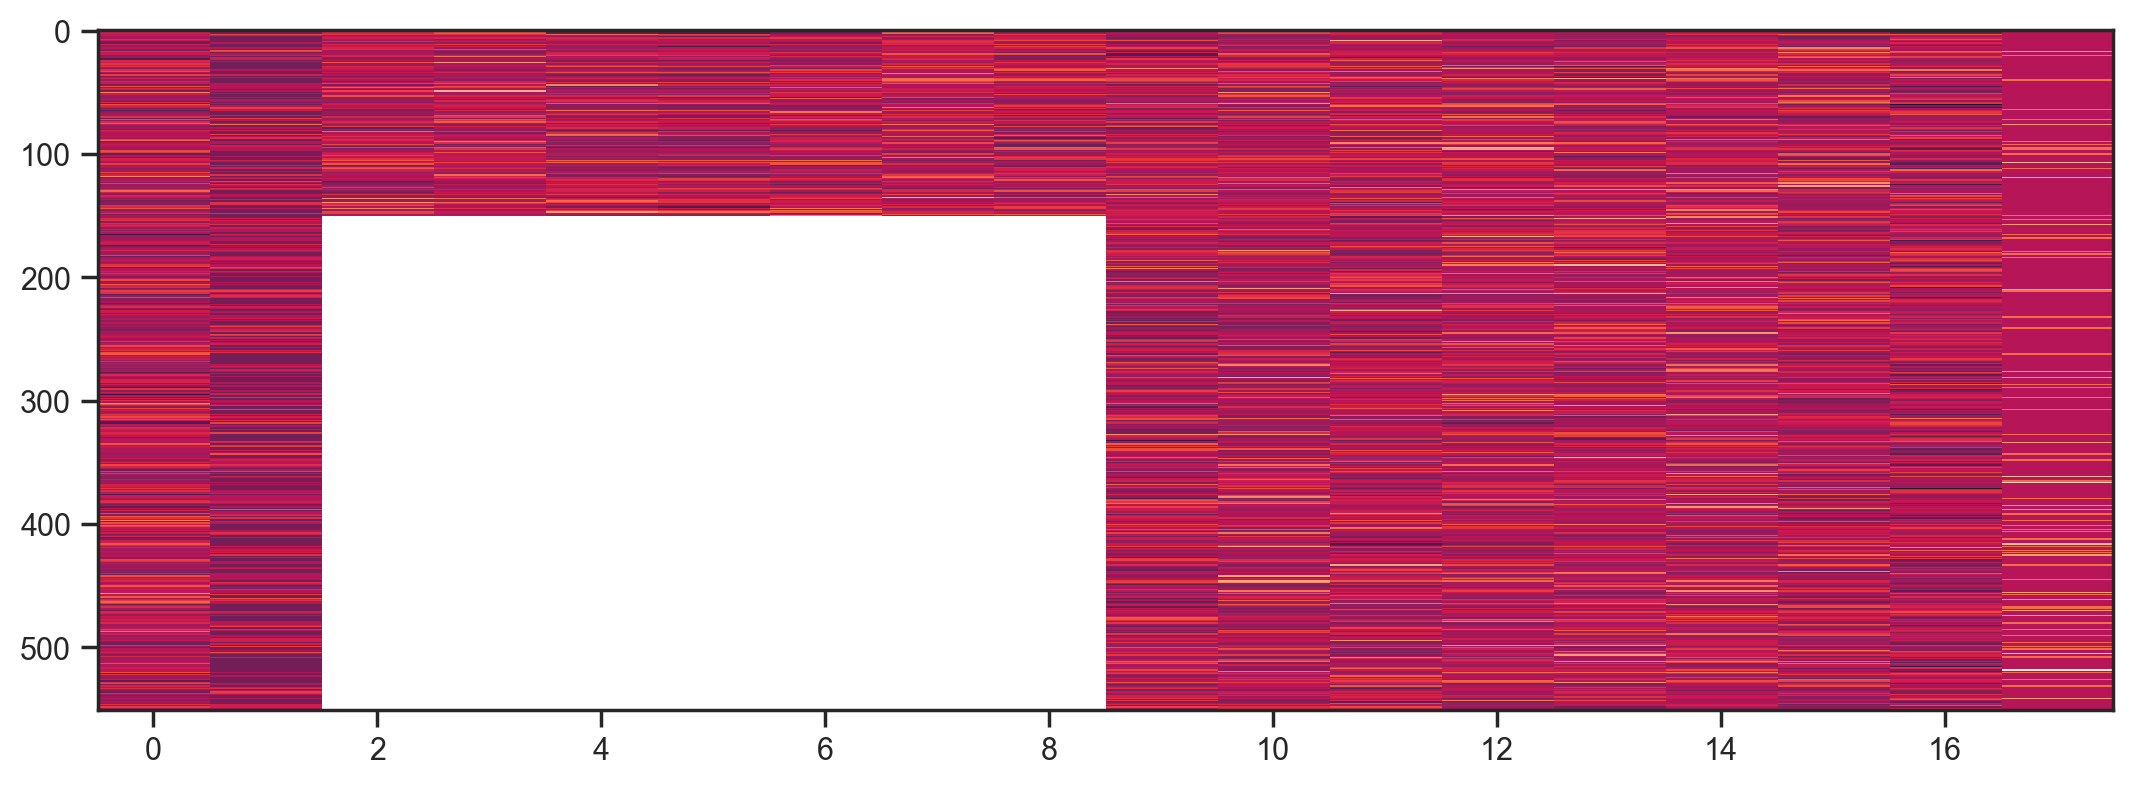

In [10]:
responses_demean = np.copy(responses)
responses_std = np.copy(responses)

means = []
stds = []

for r in range(responses.shape[1]):
    vals = responses[:, r]
    vs = vals[~np.isnan(vals)]
    responses_demean[:, r] = vals - np.median(vs)
    responses_std[:, r] = (vals - np.median(vs)) / np.std(vs)
    
    means.append(np.median(vs))
    stds.append(np.std(vs))
    
means = np.array(means)
stds = np.array(stds)
    
imshow(responses_demean, aspect='auto')

figure()
imshow(responses_std, aspect='auto')

In [11]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

responses_imputed = KNN(k=2).fit_transform(responses_std)
#responses_imputed = SoftImpute().fit_transform(responses_std)


Imputing row 1/551 with 0 missing, elapsed time: 0.068
Imputing row 101/551 with 0 missing, elapsed time: 0.069
Imputing row 201/551 with 7 missing, elapsed time: 0.086
Imputing row 301/551 with 7 missing, elapsed time: 0.098
Imputing row 401/551 with 7 missing, elapsed time: 0.109
Imputing row 501/551 with 7 missing, elapsed time: 0.120


In [12]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics.scorer import make_scorer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.neural_network import MLPRegressor
from sklearn import feature_selection


import umap

/home/pierre/.local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [13]:
conv_features.keys()

dict_keys(['conv1', 'conv2', 'conv3', 'conv4', 'conv5'])

In [14]:
feature = conv_features['conv2'][50:]

ps_all = np.zeros(feature.shape[1])

for i in range(18):
    vals = responses[:, i]
    good = ~np.isnan(vals)
    fs, ps = feature_selection.f_regression(feature[good], vals[good], center=True)
    ps_all += np.log(ps)

/home/pierre/.local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/pierre/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/pierre/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/pierre/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [15]:
ps_all[np.isnan(ps_all)] = 1

In [16]:
ps_all

array([-71.01553188, -80.88387481, -81.43390616, ..., -27.50320981,
       -41.09270619, -58.84938021])

LinregressResult(slope=-0.00543830228202919, intercept=8.06009762826721, rvalue=-0.10228779707252544, pvalue=0.016310548617955625, stderr=0.002257196718024434)
LinregressResult(slope=0.0017784055904676386, intercept=0.5951111362953545, rvalue=0.04787230918068078, pvalue=0.2619404036207209, stderr=0.0015836603589856769)
LinregressResult(slope=-0.008213514871317912, intercept=6.365664327651468, rvalue=-0.17663321151670042, pvalue=0.03004042658842696, stderr=0.00374956401202096)
LinregressResult(slope=-0.003912667877174116, intercept=0.5395880838142169, rvalue=-0.24401126202216317, pvalue=0.002533432499525499, stderr=0.001273913084878818)
LinregressResult(slope=0.006198492890940358, intercept=3.0127622234493976, rvalue=0.1320596399722618, pvalue=0.1060125240127117, stderr=0.0038115573605189985)
LinregressResult(slope=0.013334399427854653, intercept=7.152999961211622, rvalue=0.19988291512774348, pvalue=0.013867545272434896, stderr=0.0053548937491583355)
LinregressResult(slope=-0.0123045181

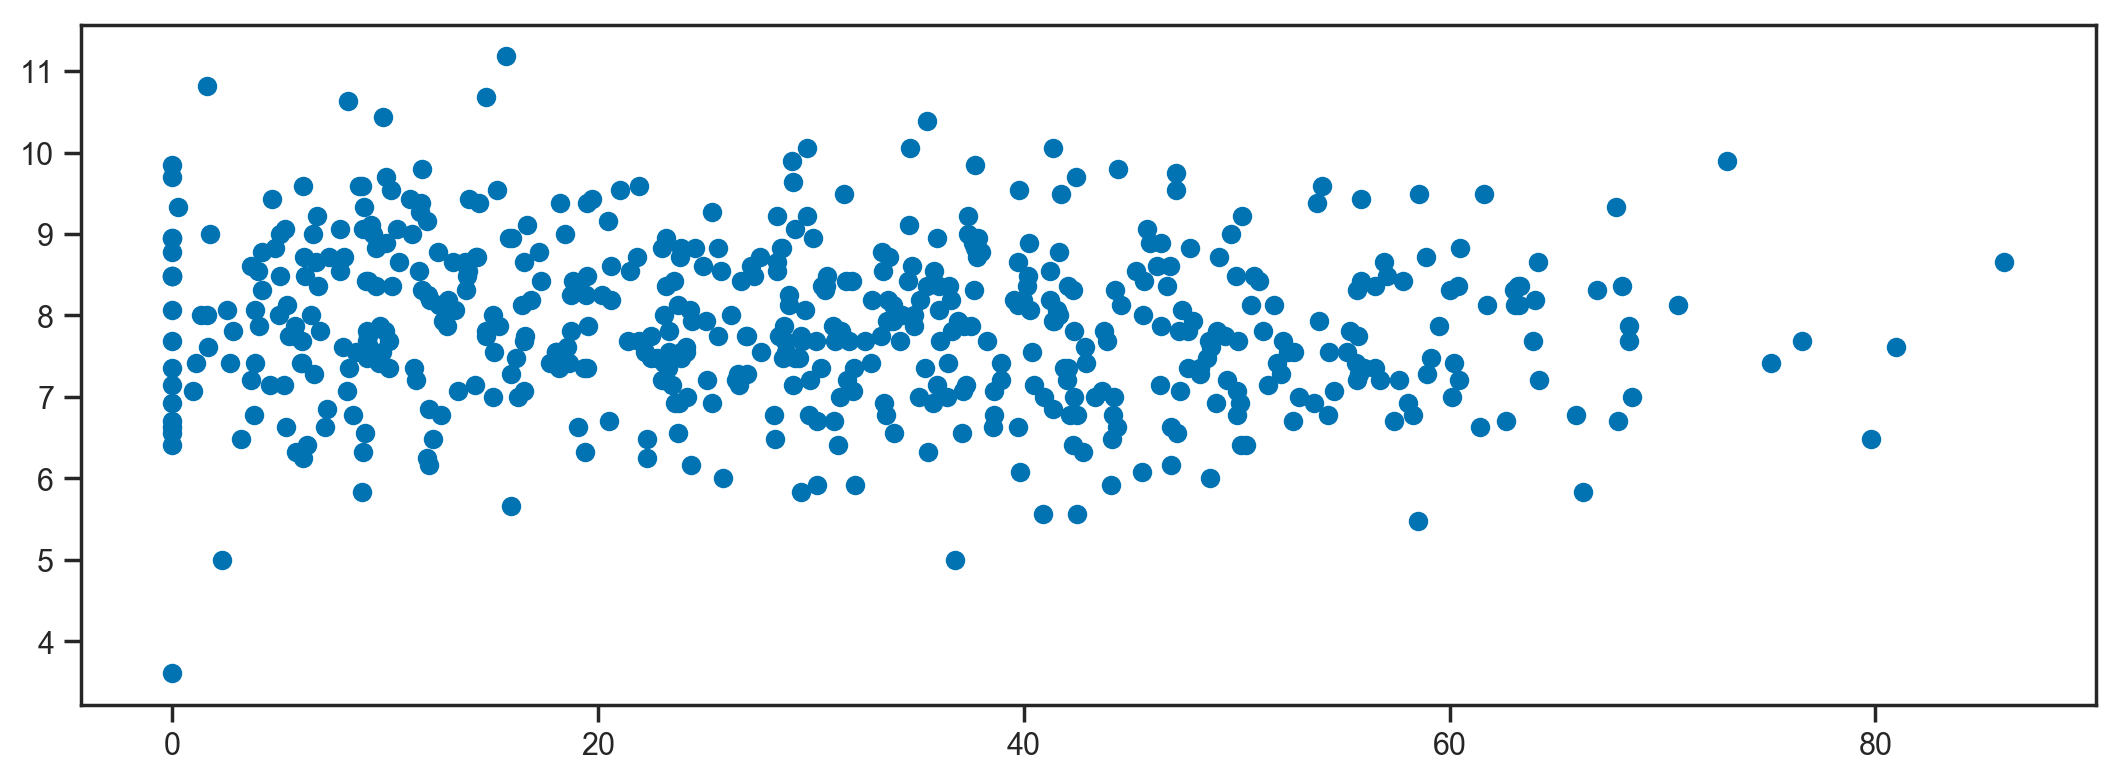

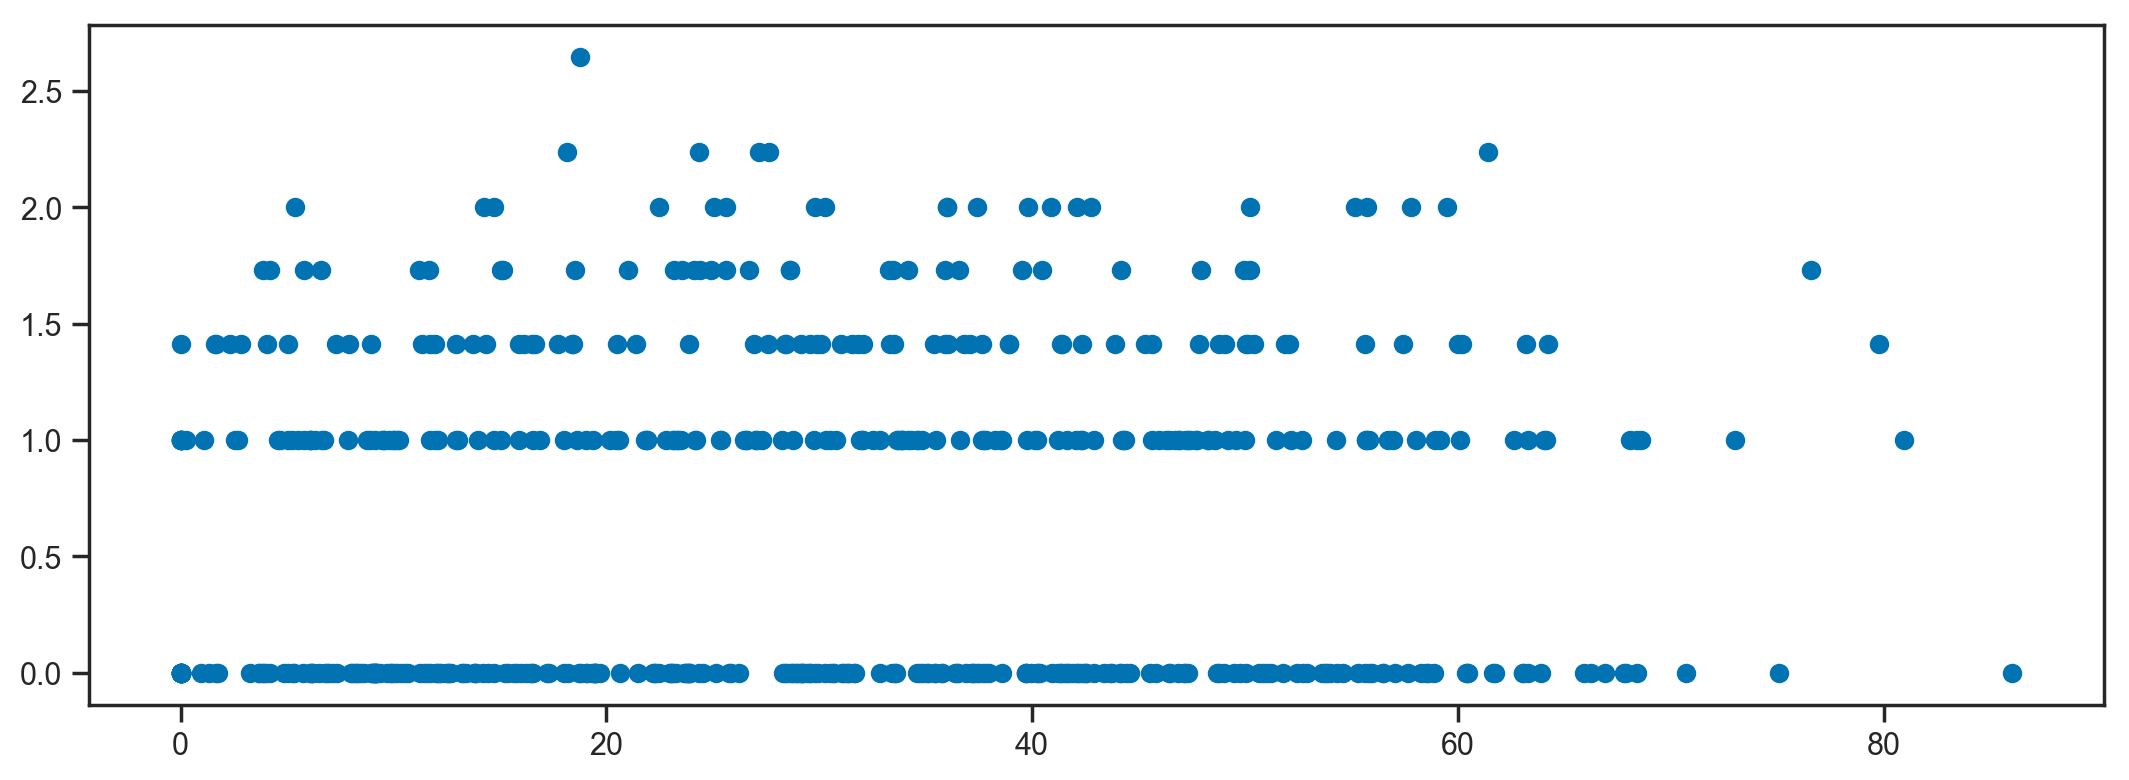

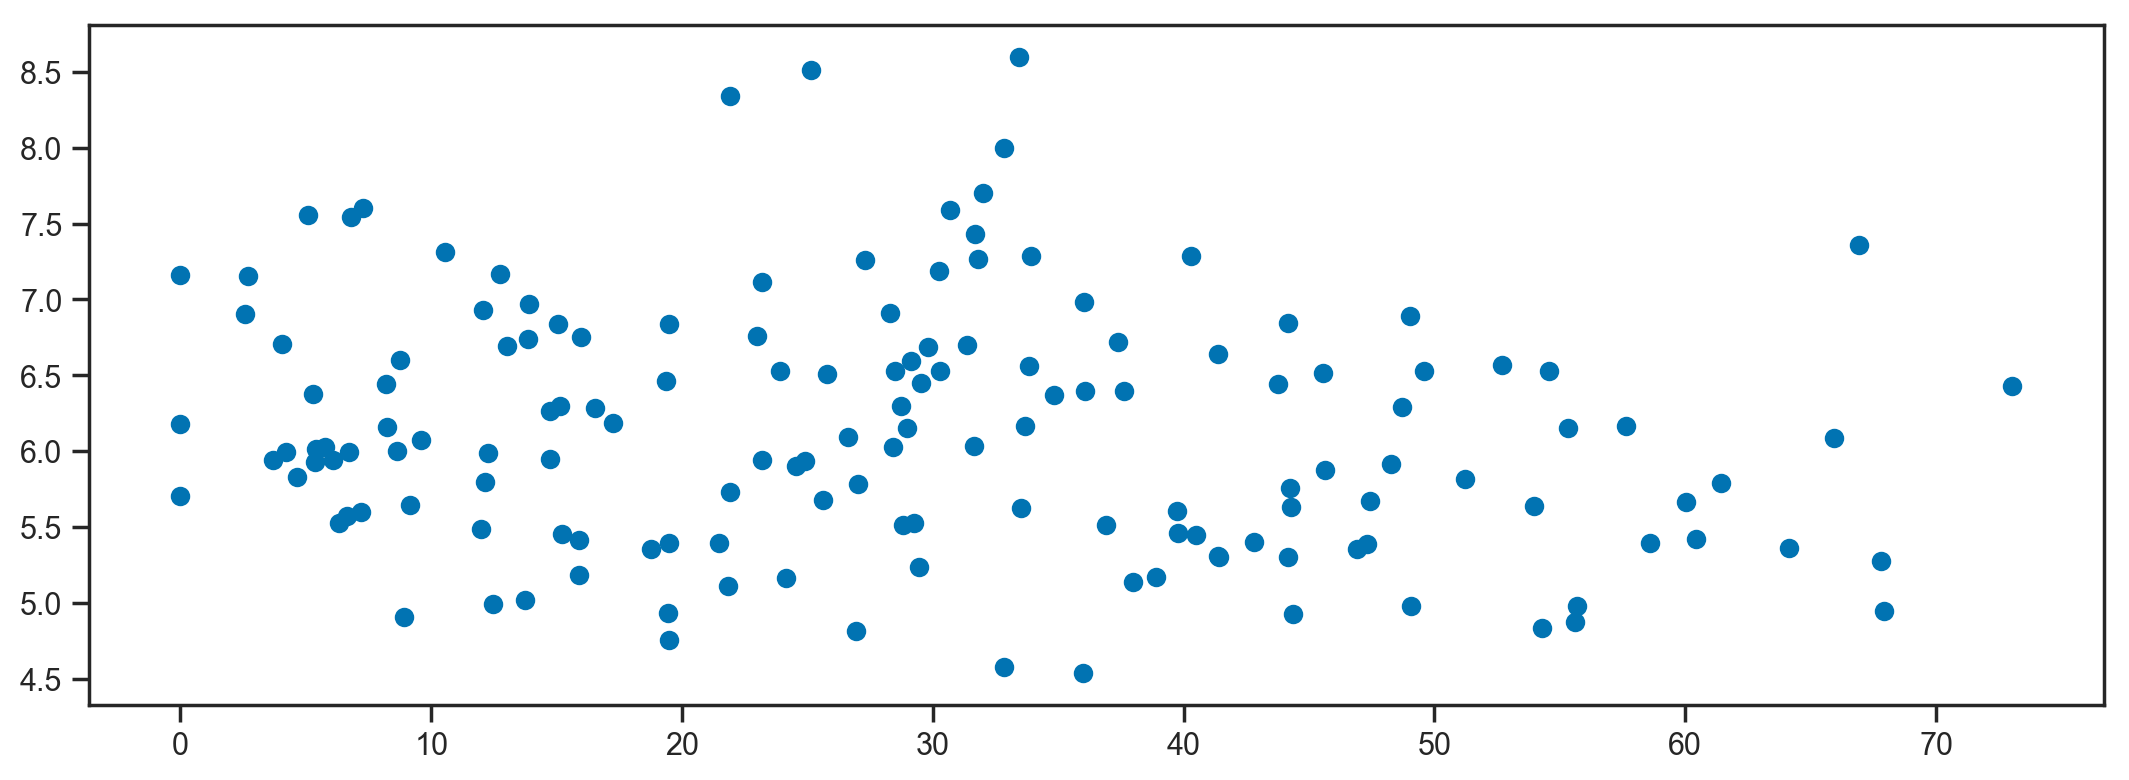

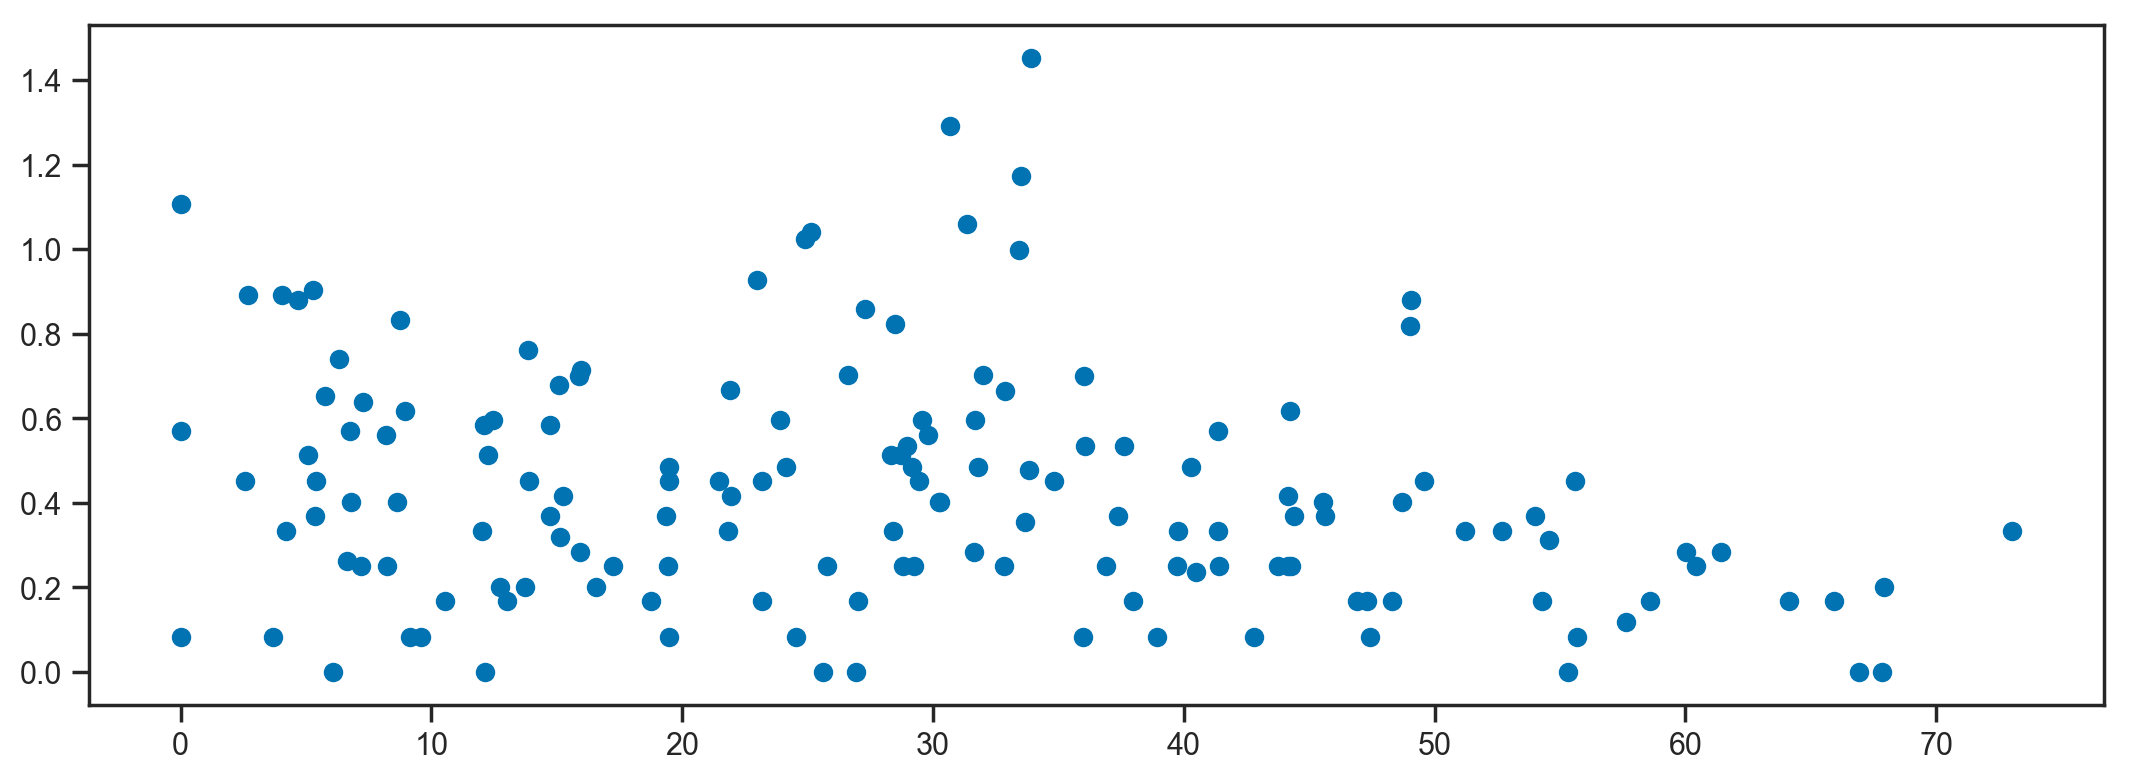

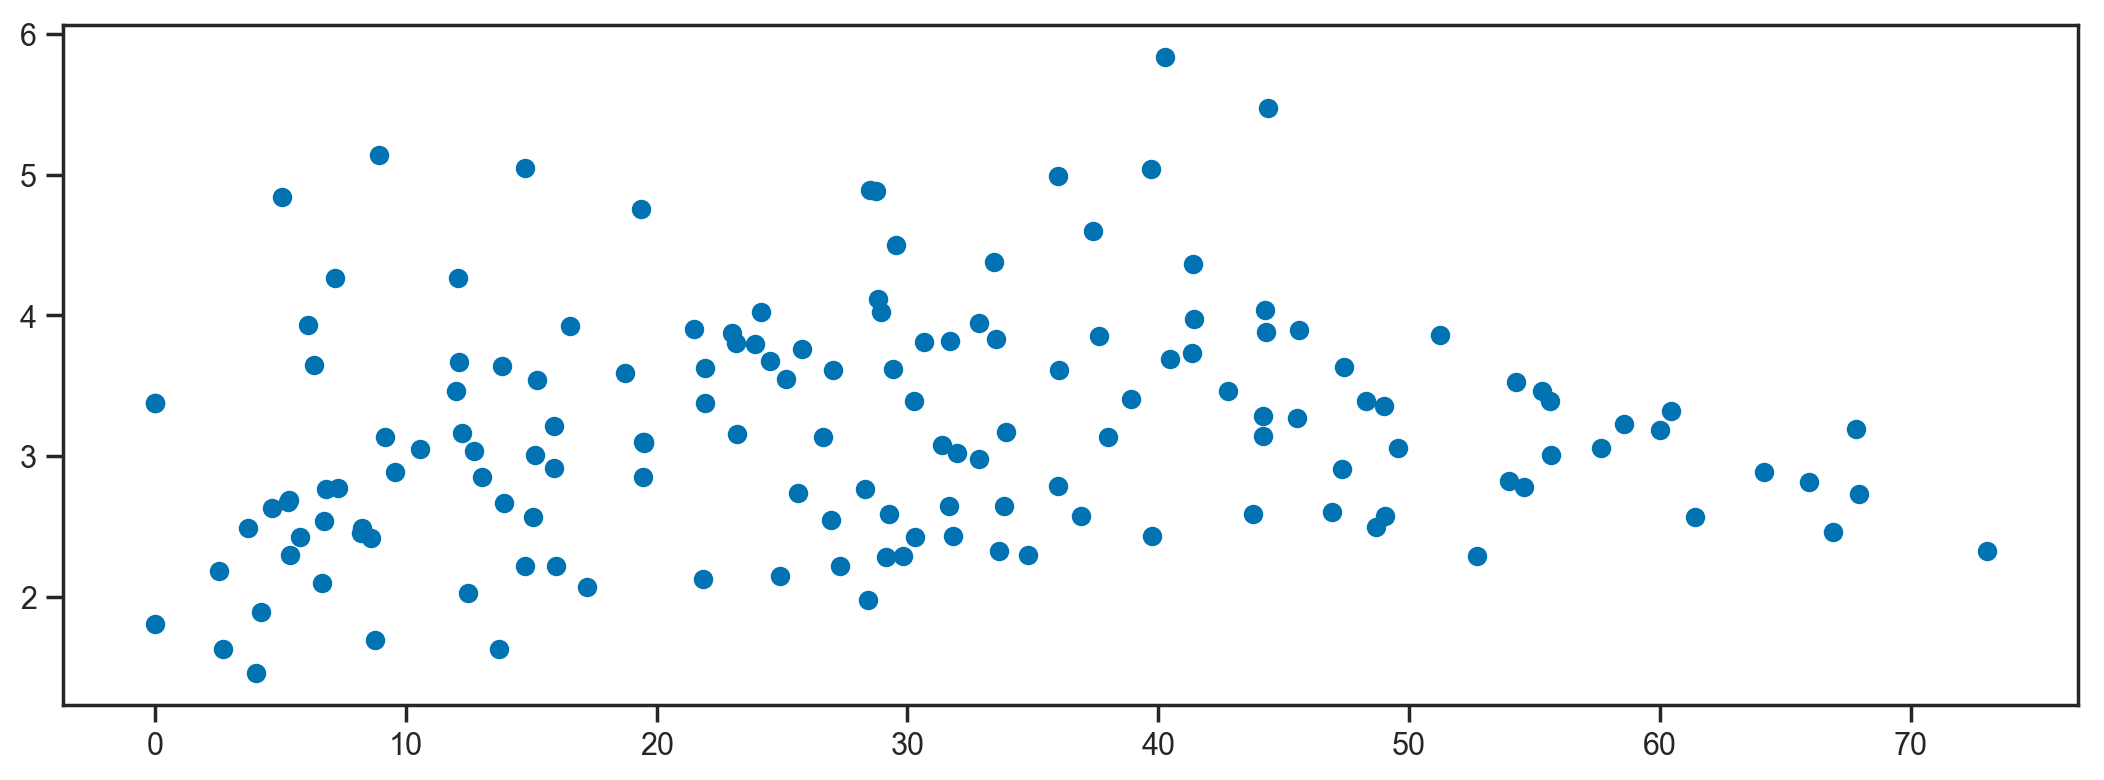

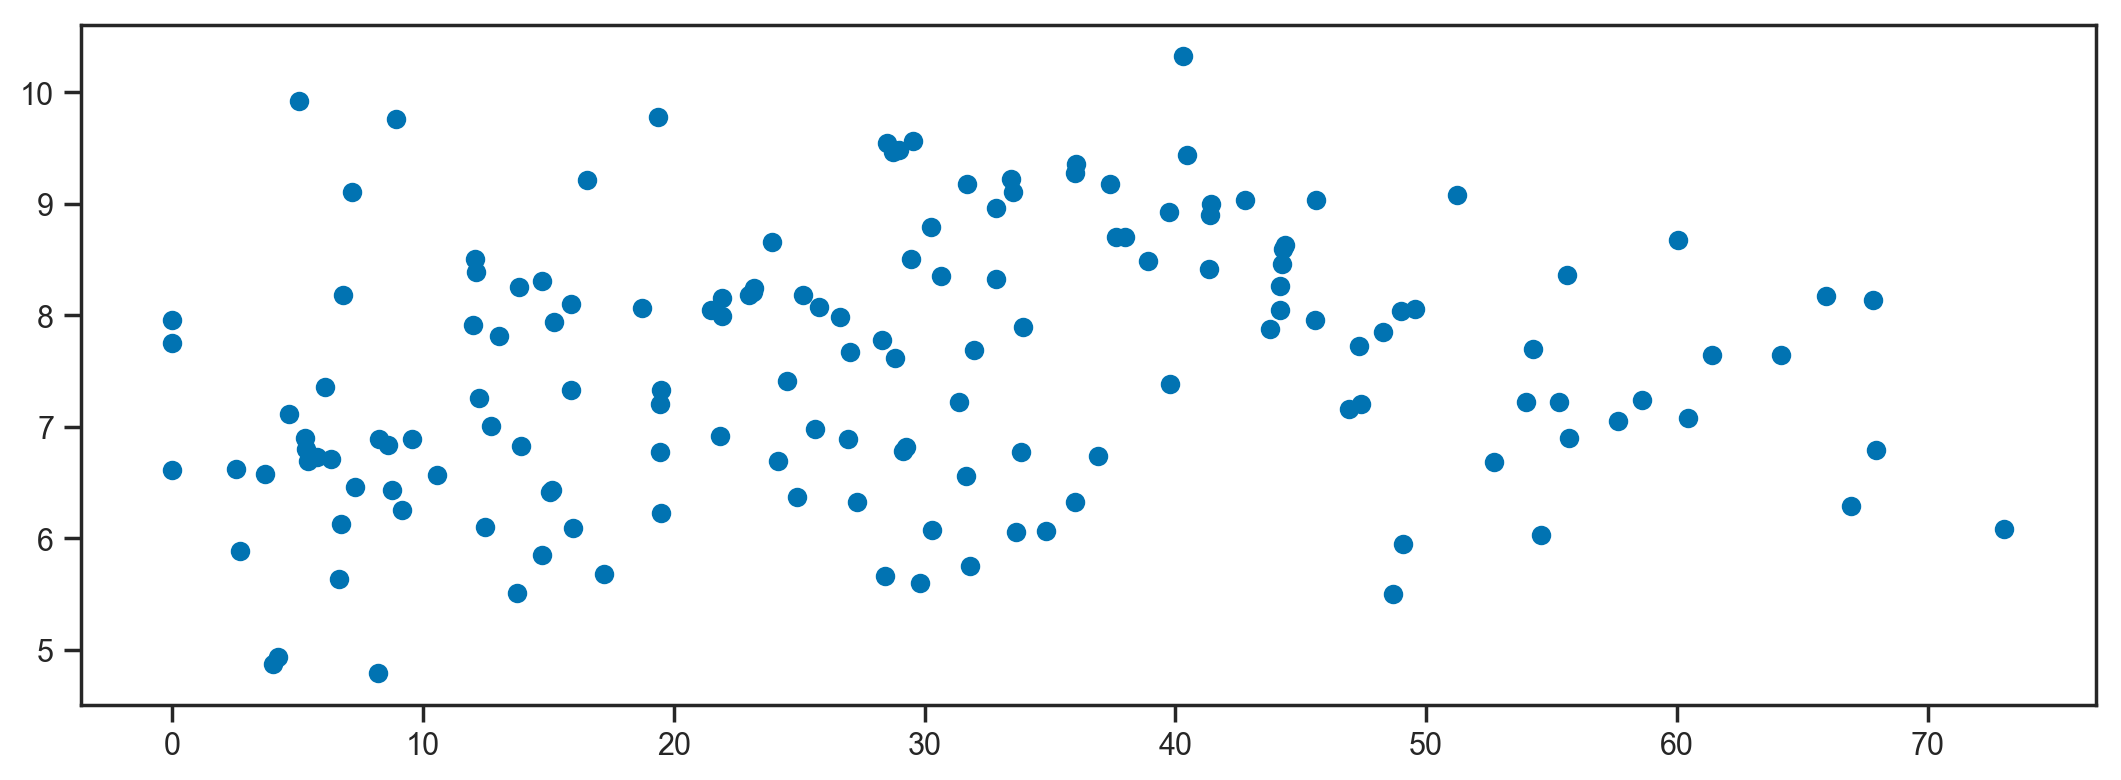

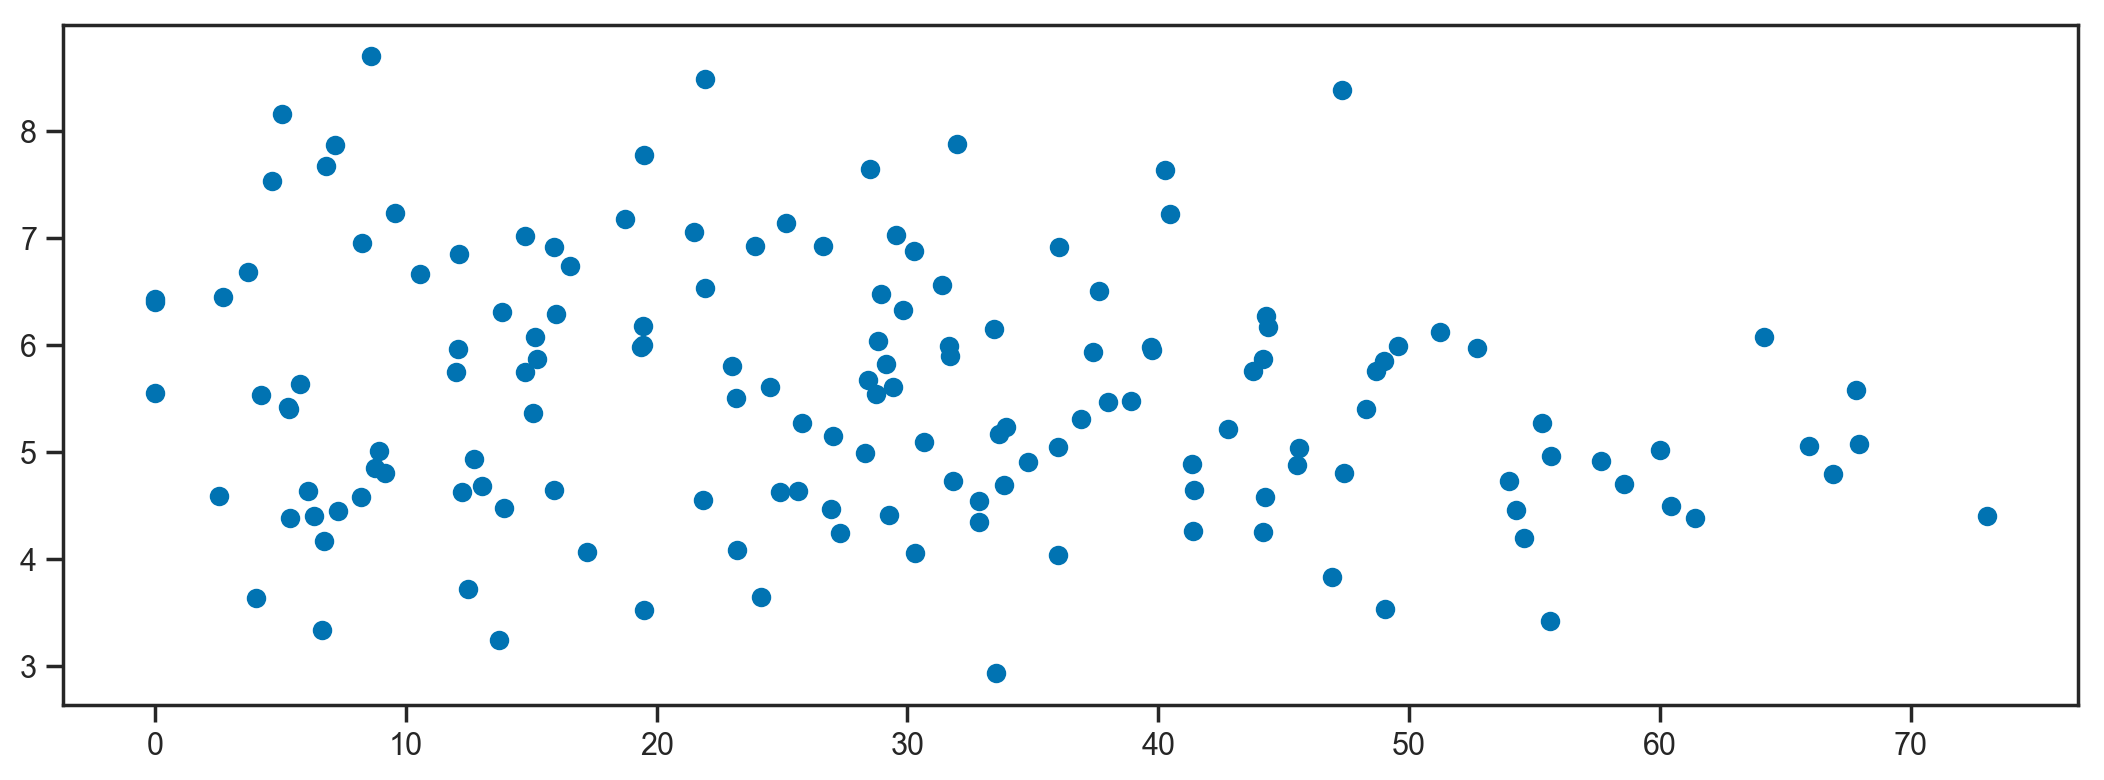

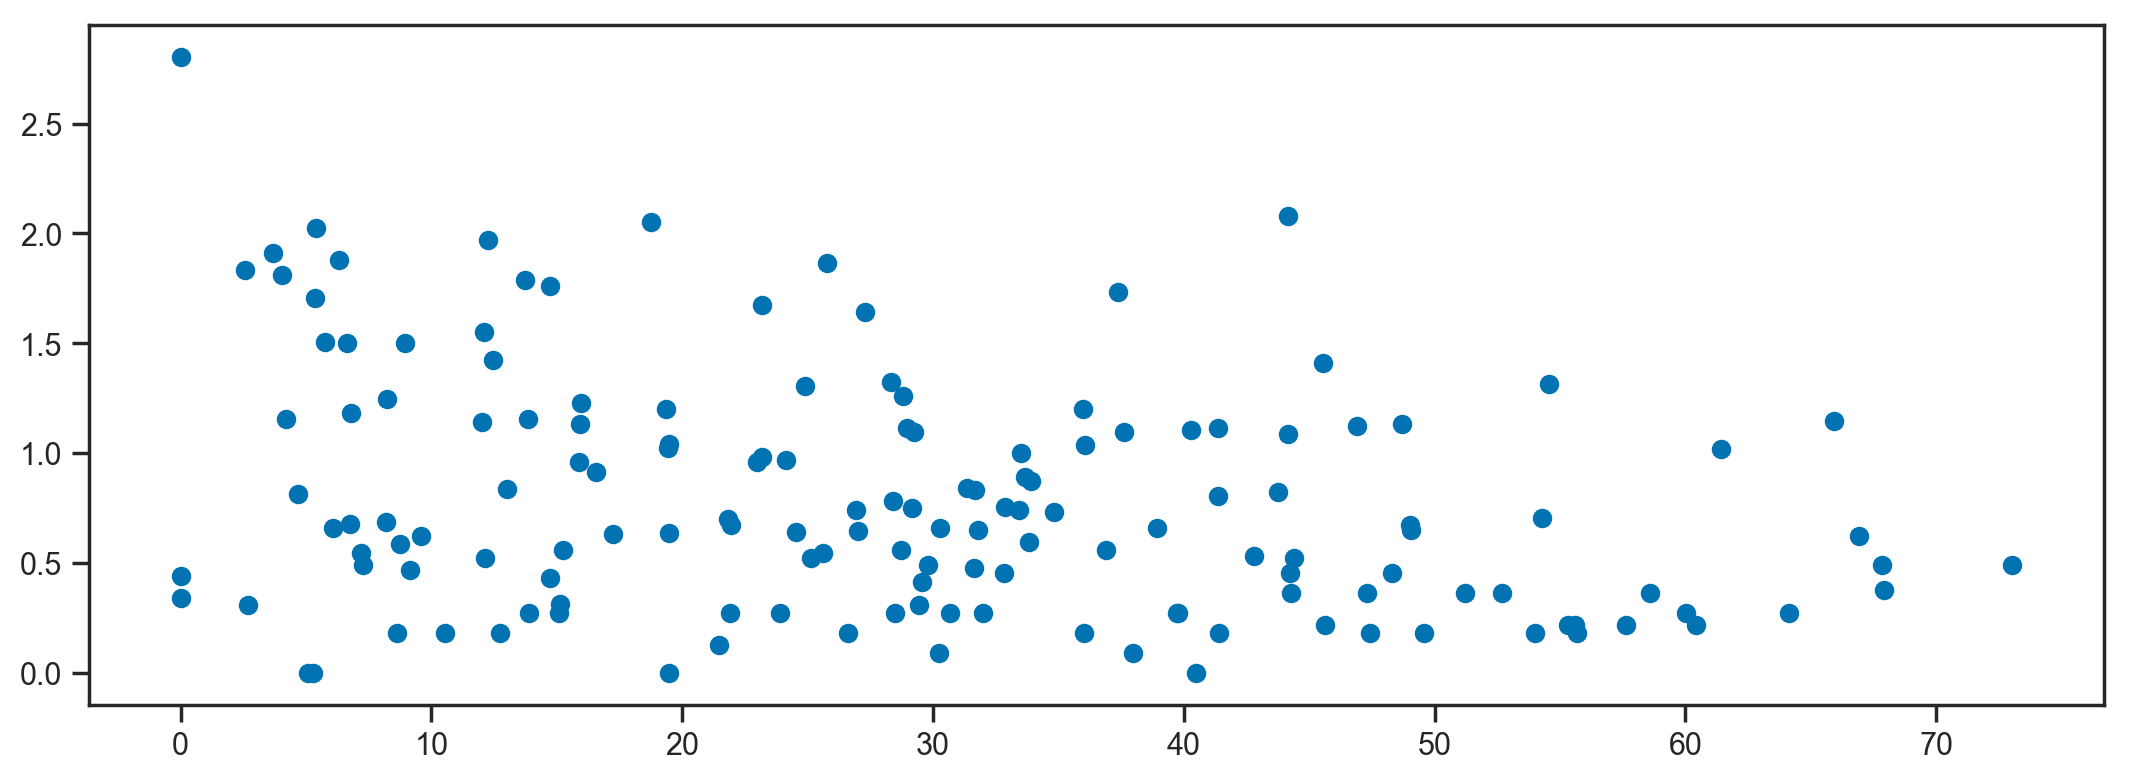

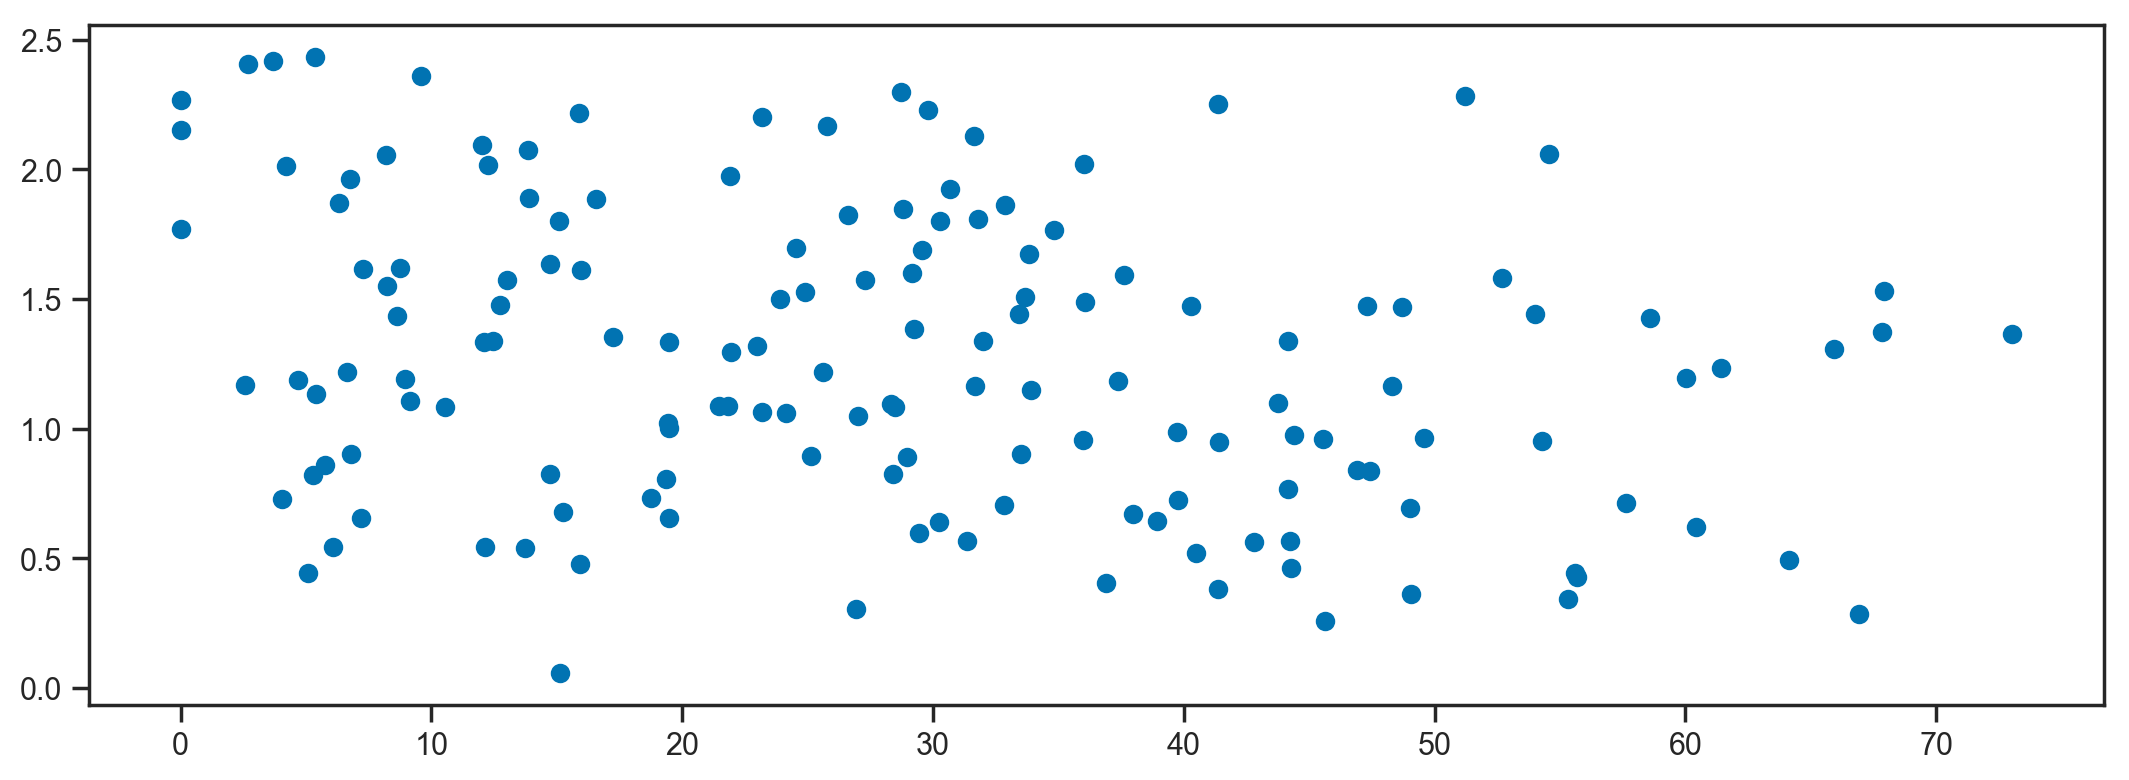

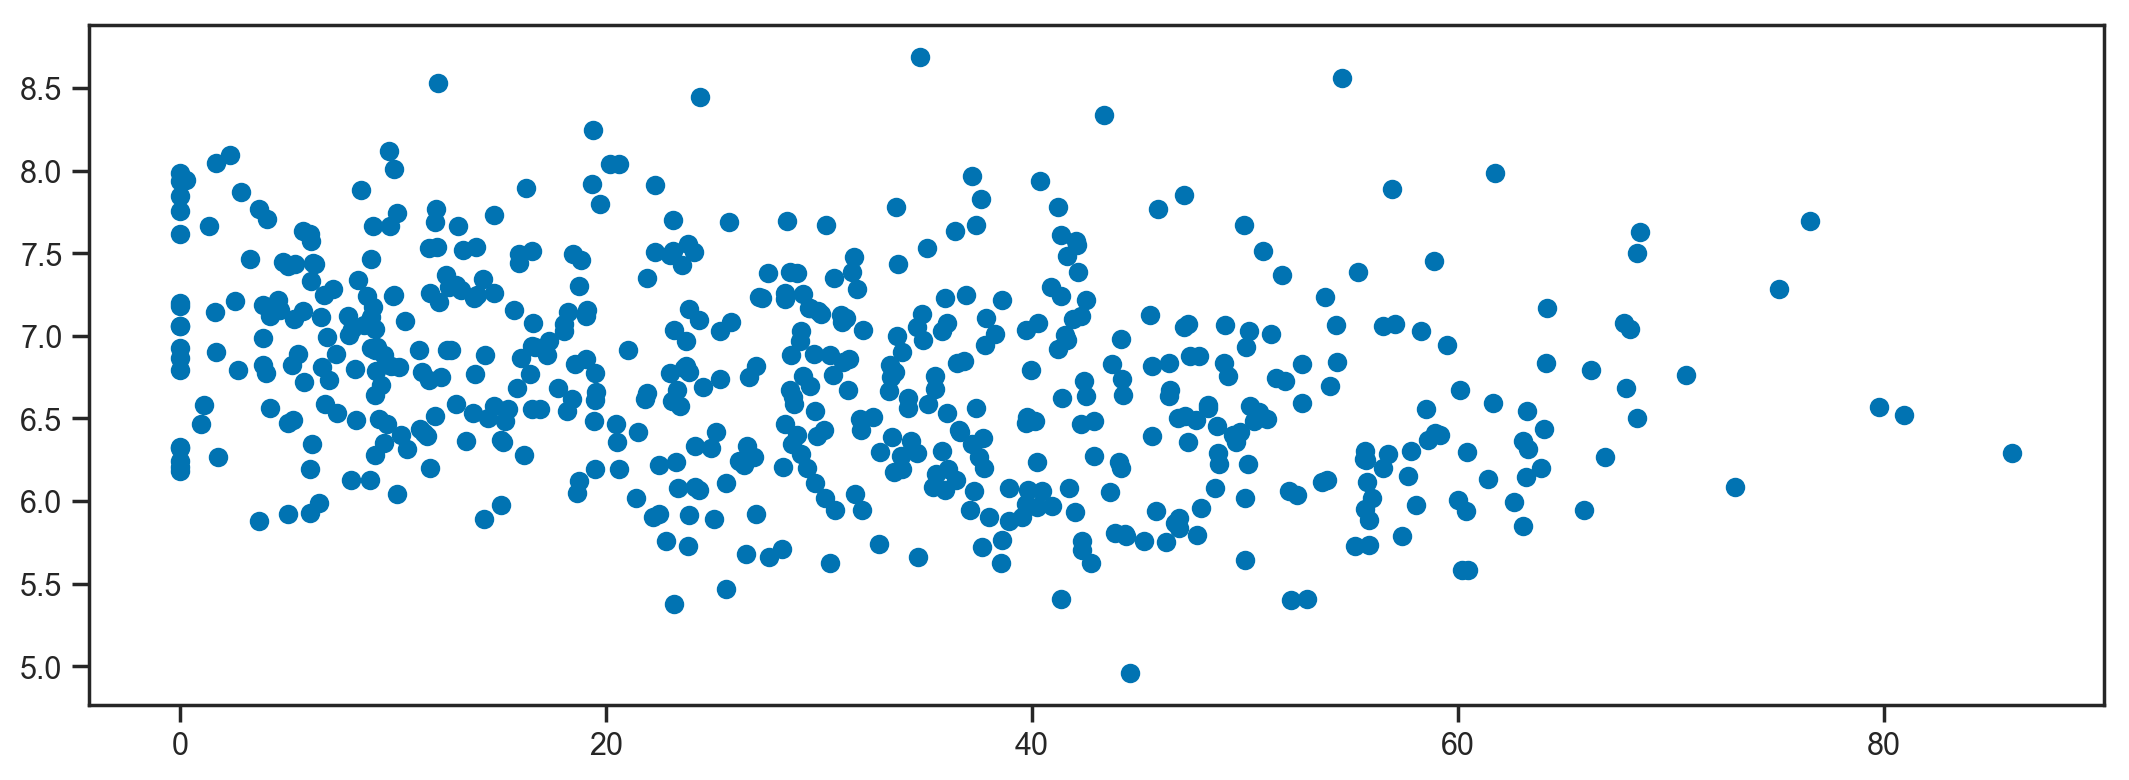

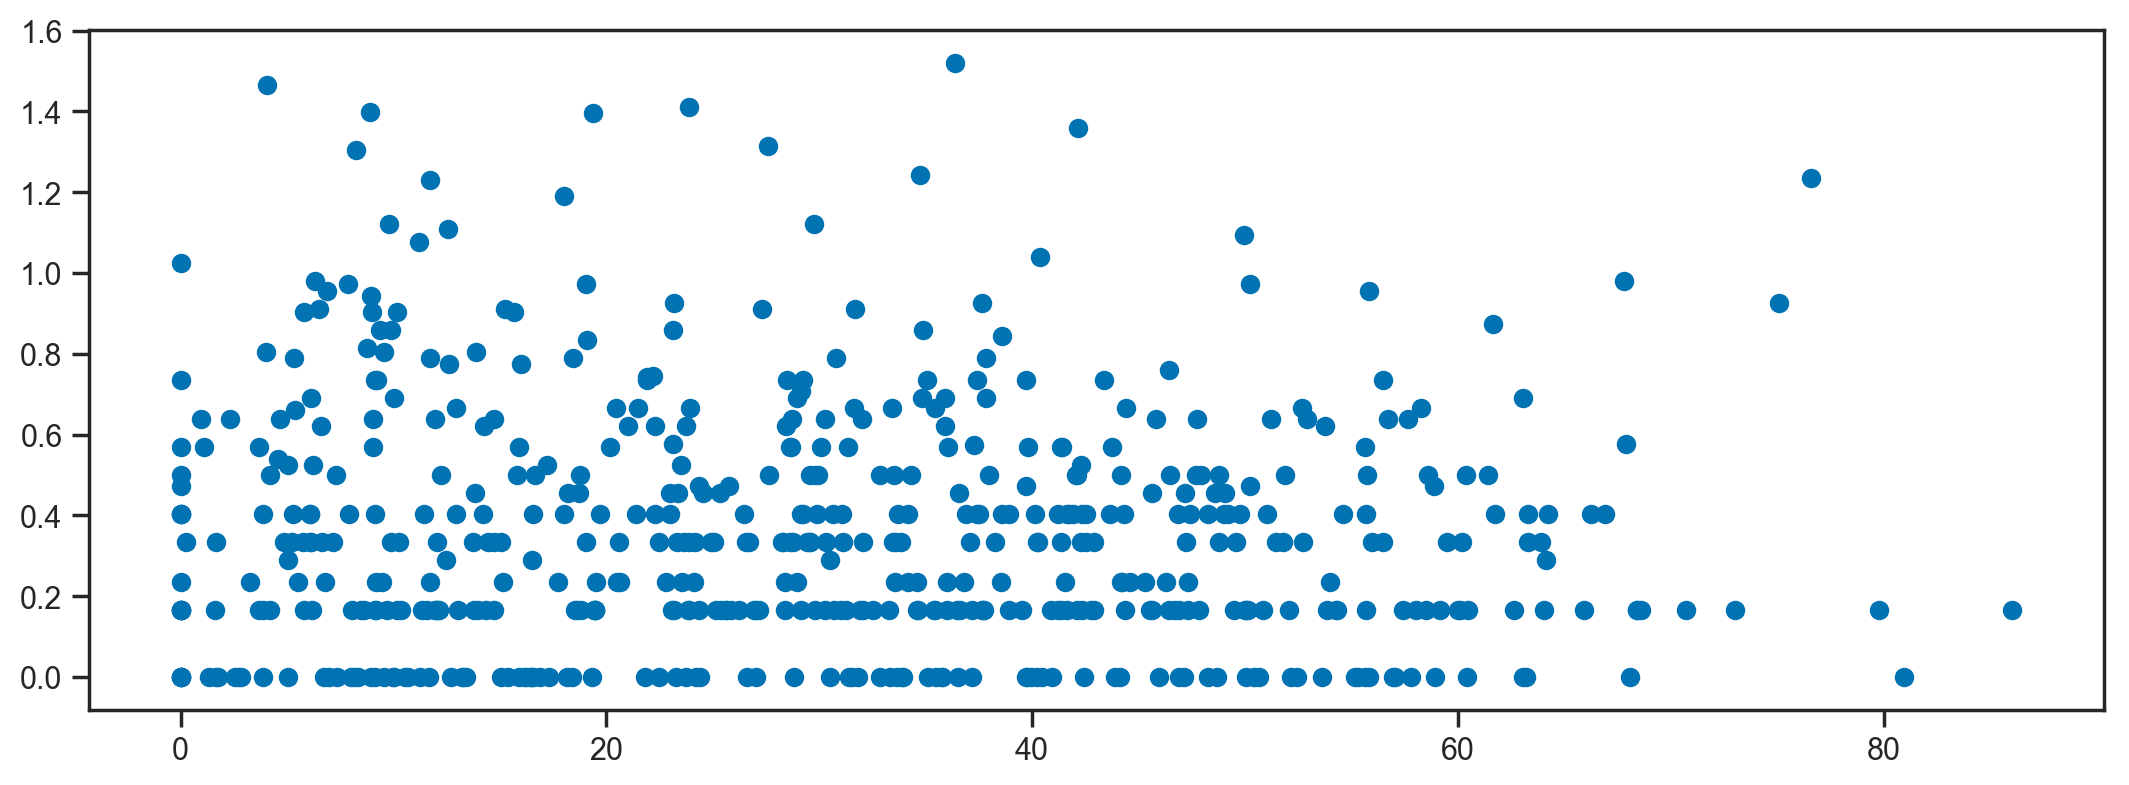

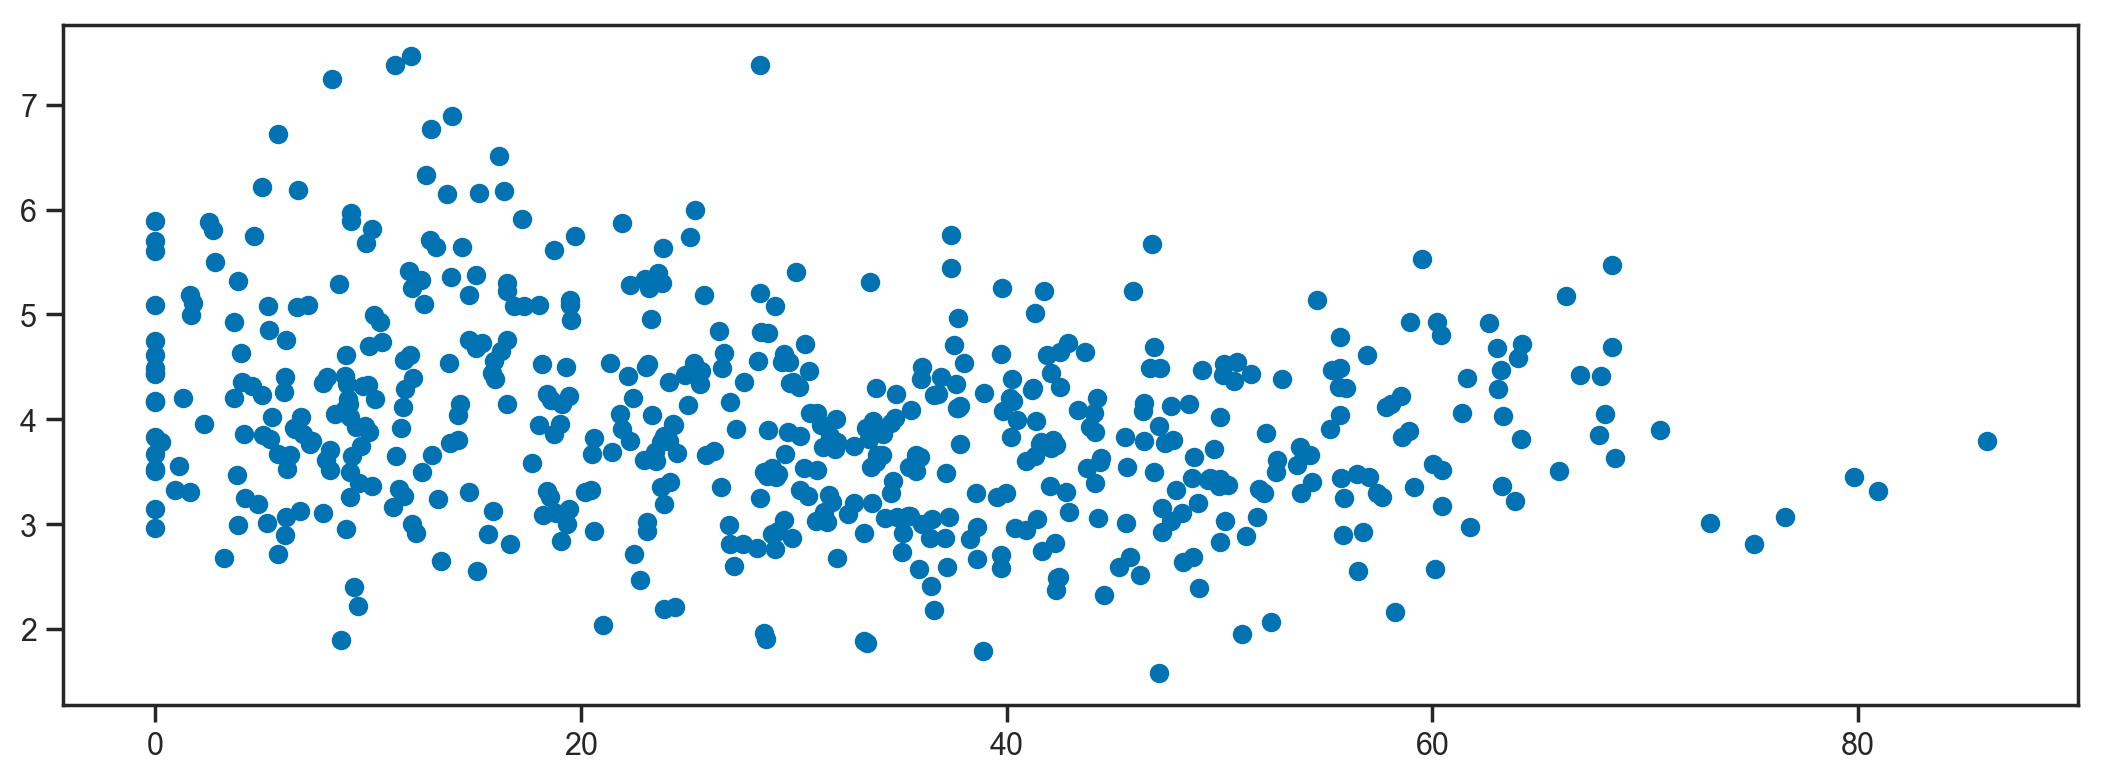

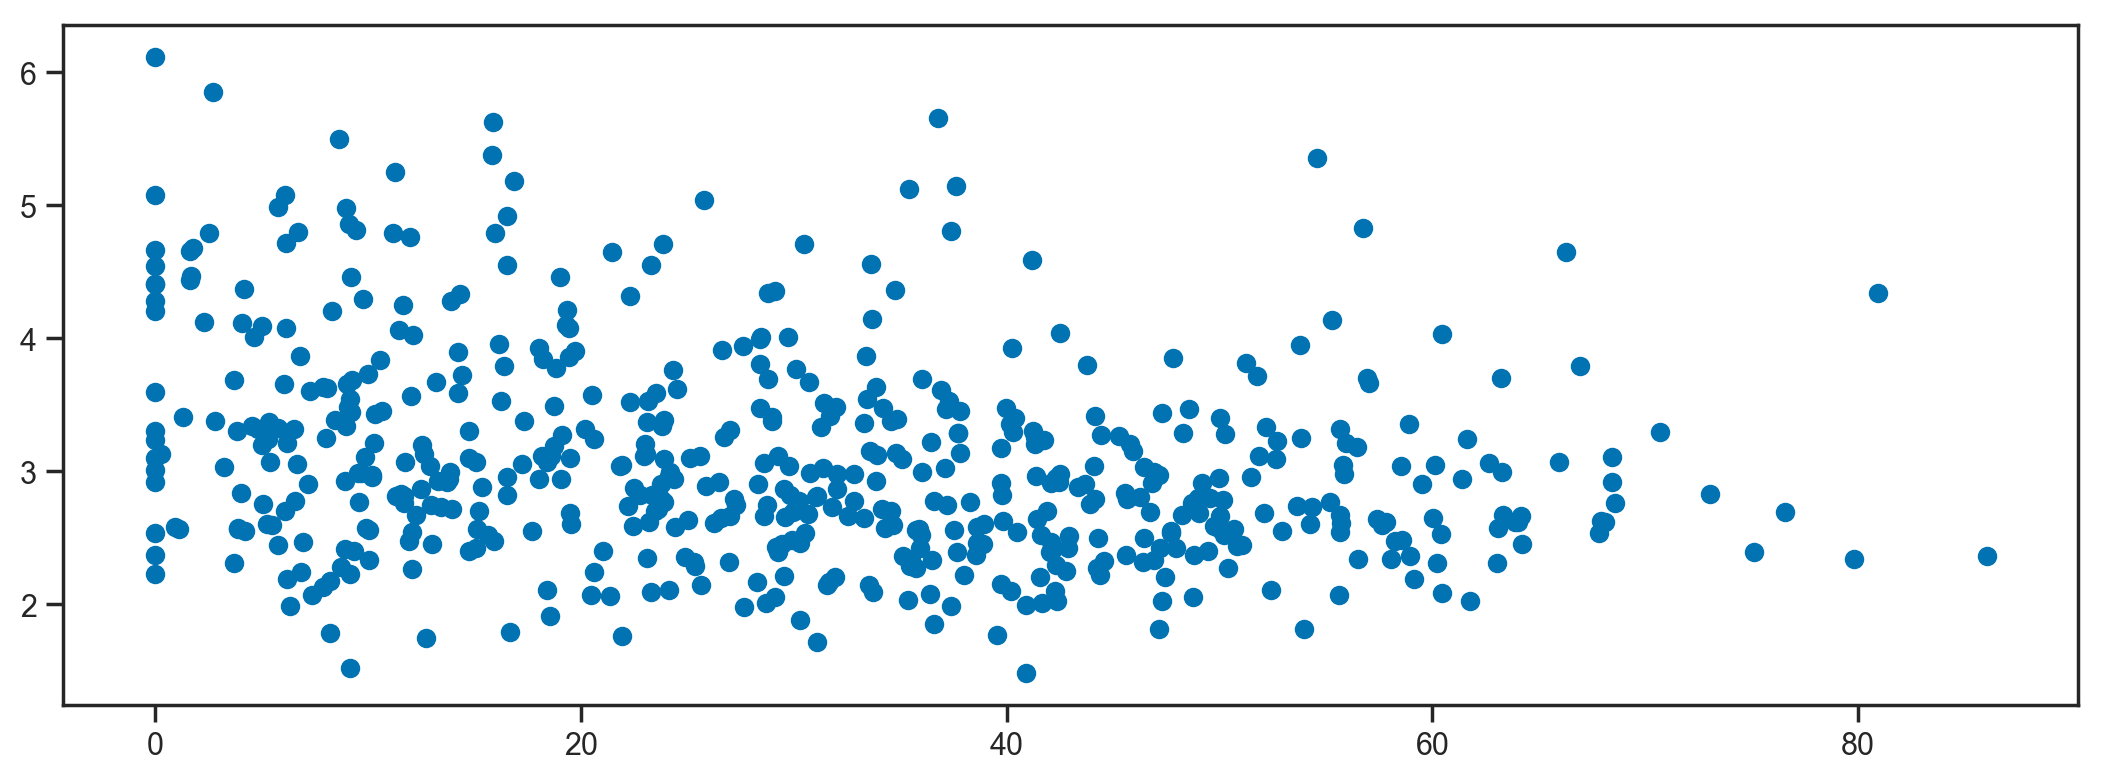

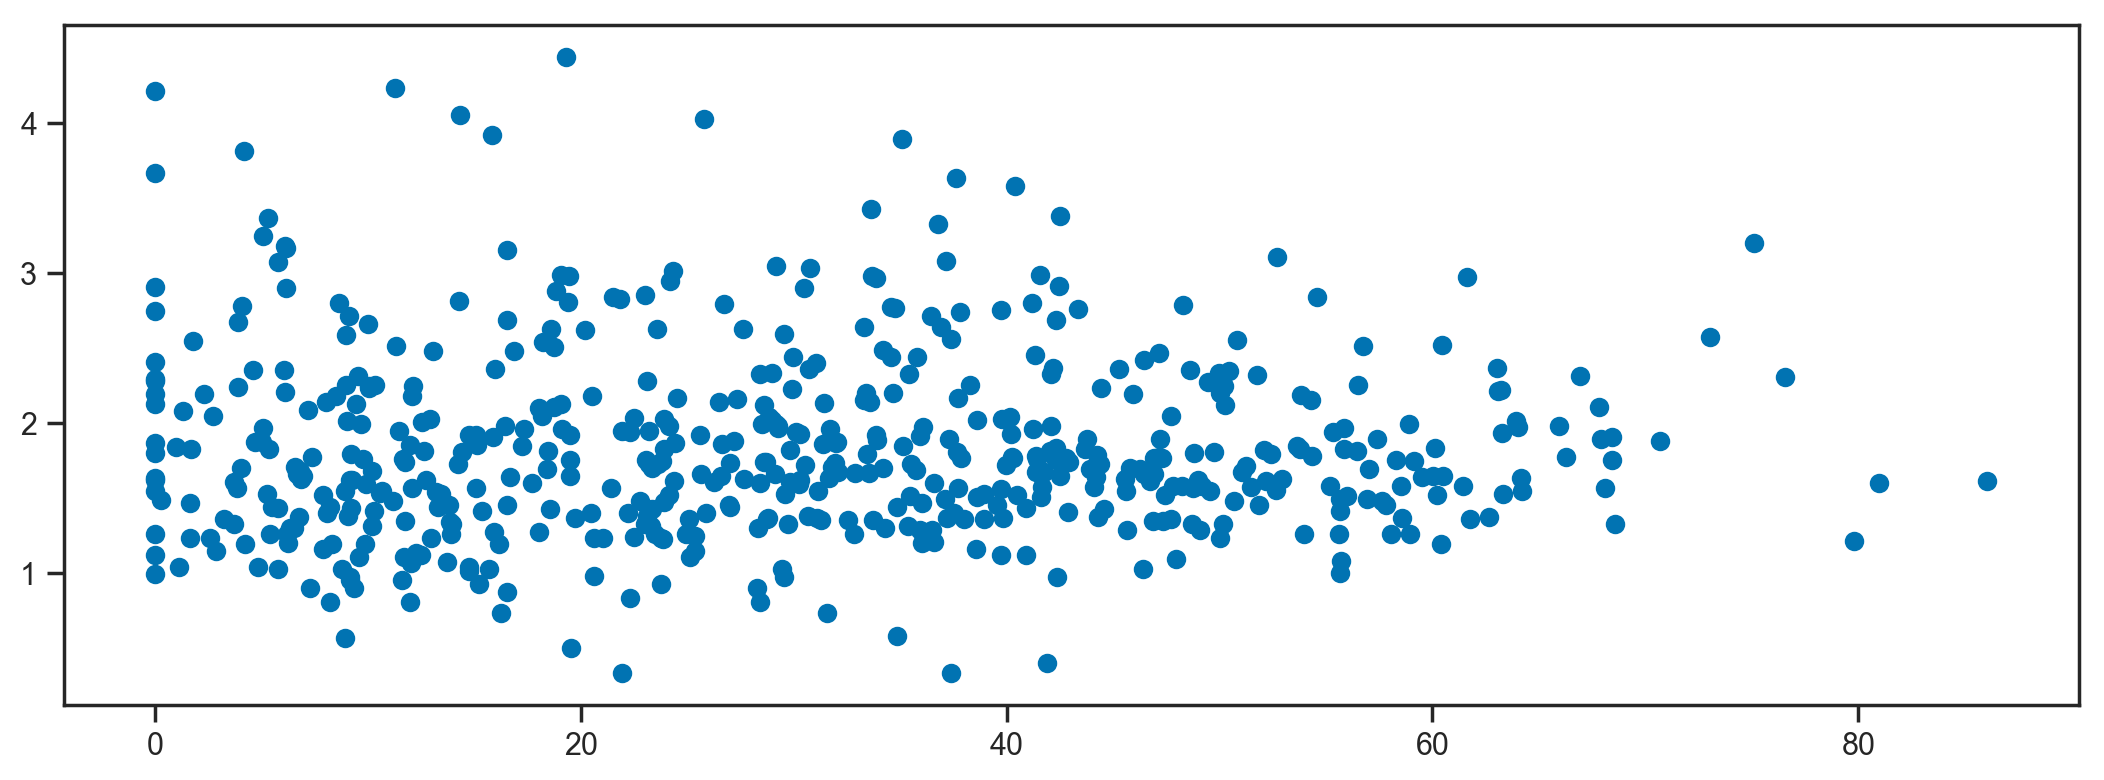

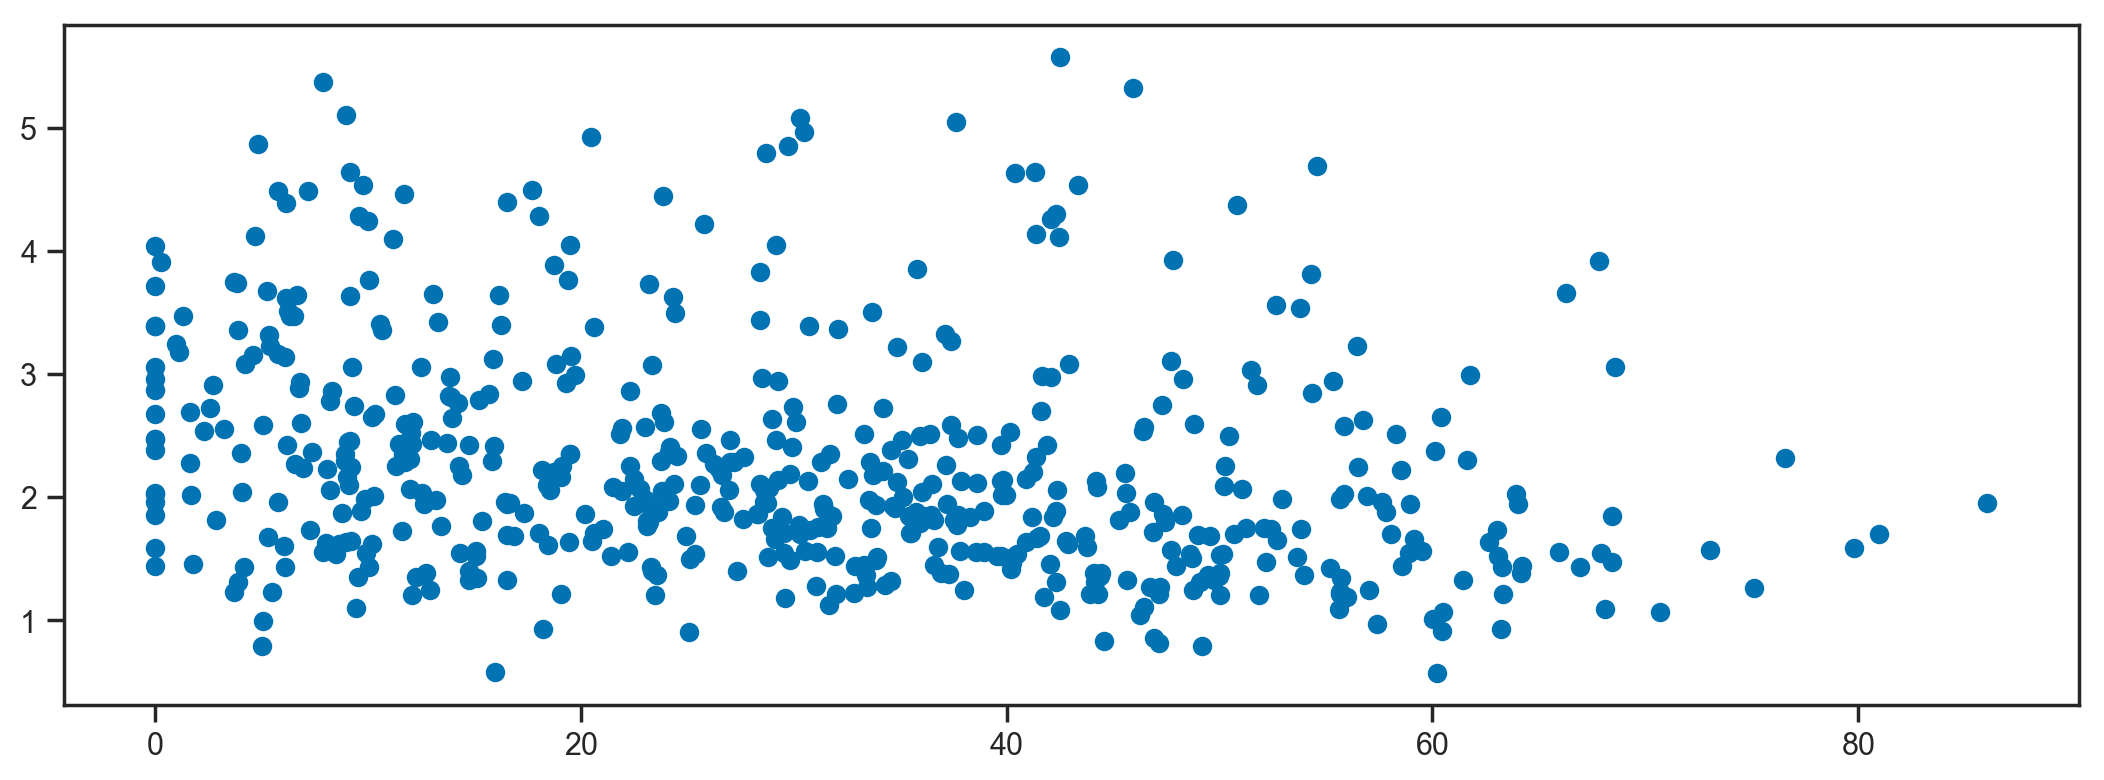

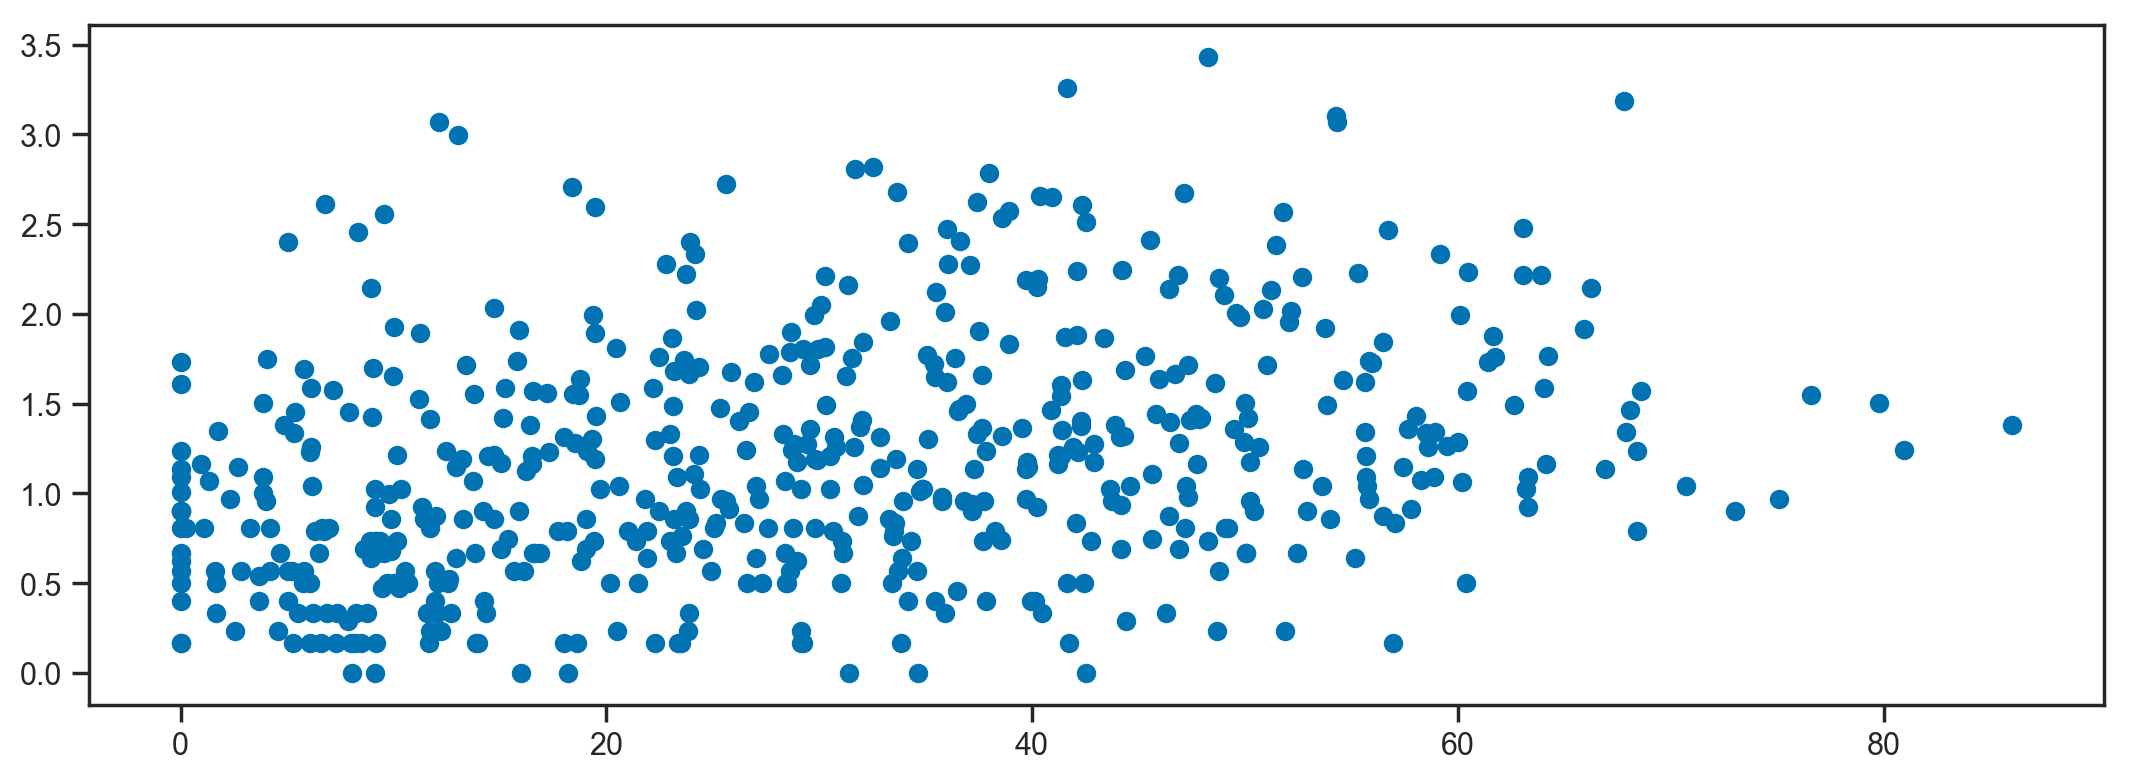

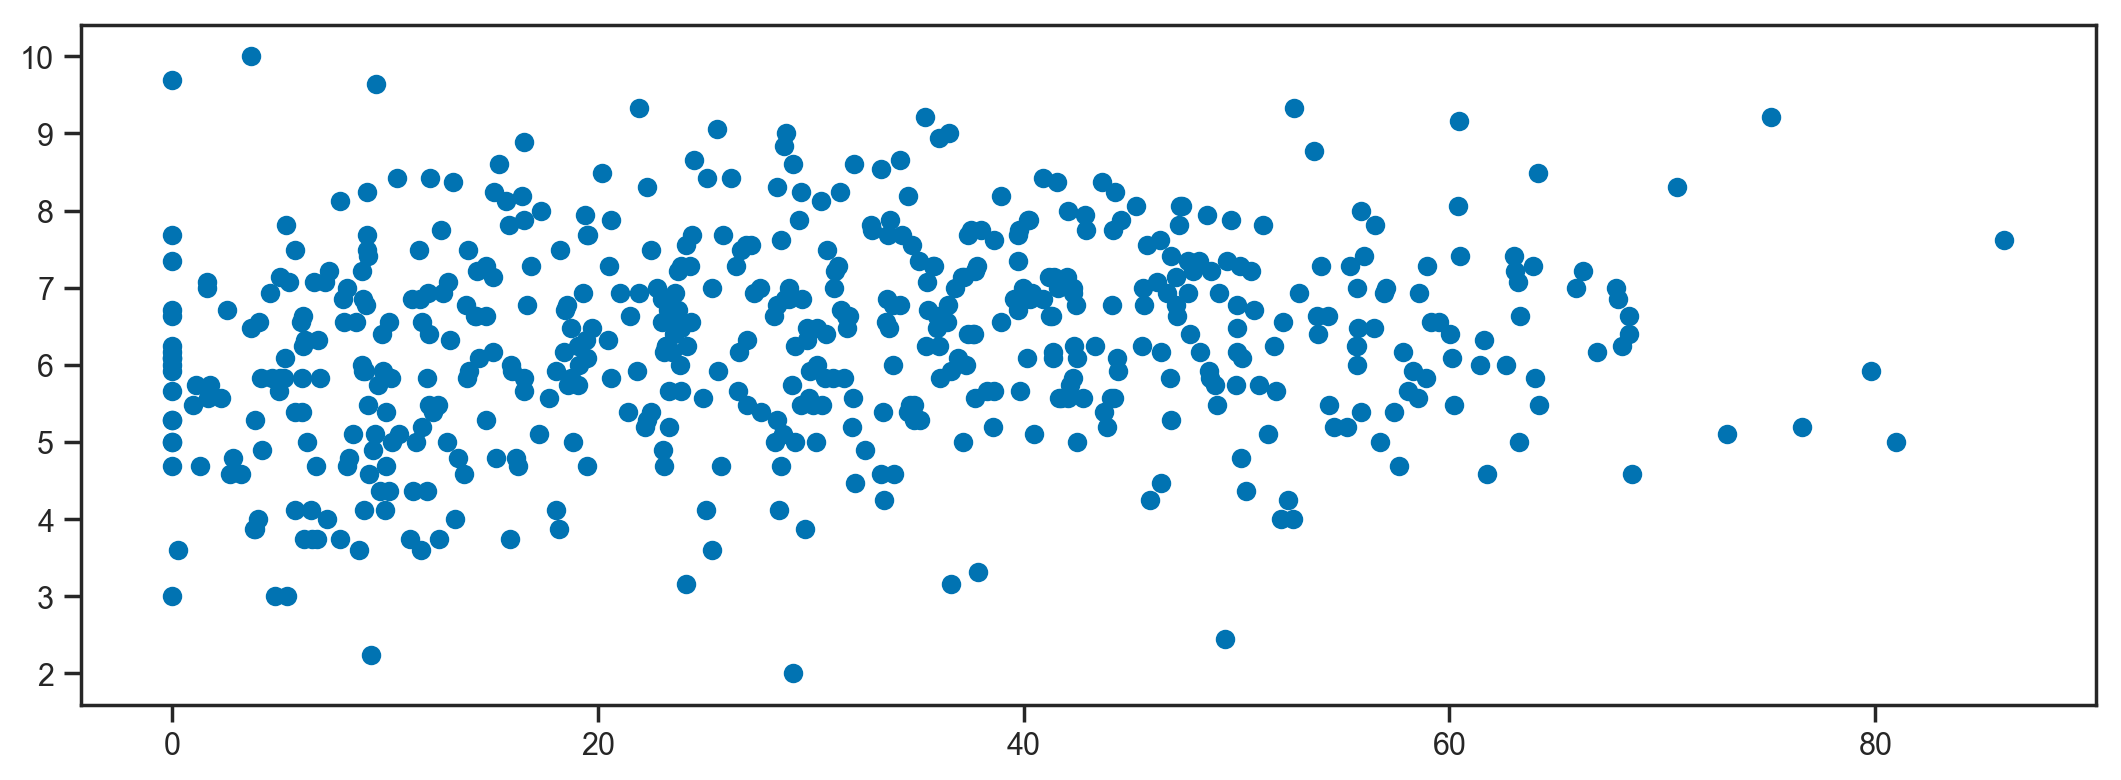

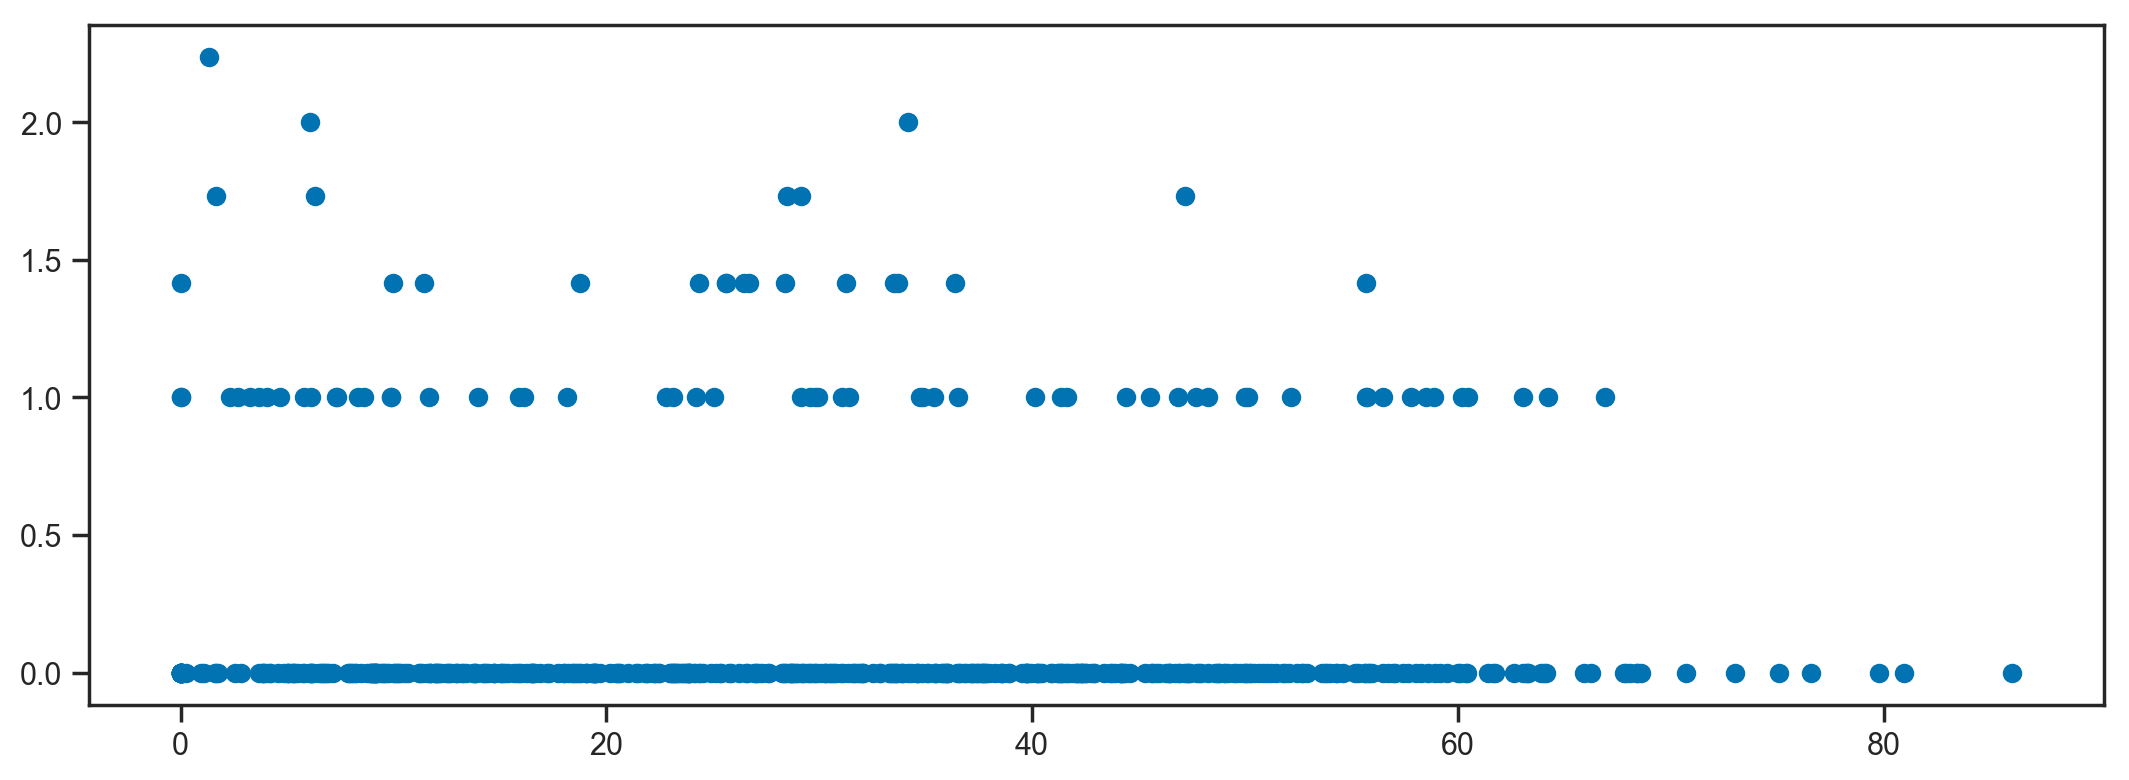

In [17]:
pix = np.argsort(ps_all)[0]

for i in range(18):
    vals = responses[:, i]
    good = ~np.isnan(vals)
    x, y = feature[good, pix], vals[good]
    print(stats.linregress(x, y))
    figure()
    scatter(x, y)

In [18]:
pcs_lab = PCA(n_components=30).fit_transform(features['LAB'])
pcs_fourier = PCA(n_components=30).fit_transform(features['fourier'])
pcs_gabor = PCA(n_components=20).fit_transform(features['gabor'])

In [19]:
pcs_conv1 = PCA(n_components=30).fit_transform(conv_features['conv1'])
pcs_conv2 = PCA(n_components=10).fit_transform(conv_features['conv2'])
pcs_conv3 = PCA(n_components=10).fit_transform(conv_features['conv3'])
pcs_conv4 = PCA(n_components=10).fit_transform(conv_features['conv4'])
pcs_conv5 = PCA(n_components=10).fit_transform(conv_features['conv5'])


In [20]:
pcs_vgg5 = PCA(n_components=30).fit_transform(vgg_features['vgg5'])

In [21]:
pcs_vgg6 = PCA(n_components=30).fit_transform(vgg_features['vgg6'])
pcs_vgg7 = PCA(n_components=30).fit_transform(vgg_features['vgg7'])
pcs_vgg8 = PCA(n_components=30).fit_transform(vgg_features['vgg8'])
pcs_vgg9 = PCA(n_components=30).fit_transform(vgg_features['vgg9'])

In [22]:
import cv2
def get_edges(im):
    dx = cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize=3)
    absr = np.abs(dx + dy*1j)
    return absr

In [23]:
images_flat = images[:, 20:-20,20:-20].reshape(images.shape[0], -1)
# images_flat = images.reshape(images.shape[0], -1)

embedding = umap.UMAP(metric='correlation', min_dist=1.0, n_components=100)
X_embed = embedding.fit_transform(images_flat)

In [24]:
images_cropped = images[:, 20:-20,20:-20]
images_edges = [get_edges(im) for im in images_cropped]
images_edges = np.array(images_edges)
images_edges_flat = images_edges.reshape(images.shape[0], -1)

In [25]:
embedding = umap.UMAP(metric='correlation', min_dist=1.0, n_components=10)
X_embed_edges = embedding.fit_transform(images_edges_flat)

In [26]:
embedding = umap.UMAP(metric='correlation', min_dist=1.0, n_components=10)
X_embed_fourier = embedding.fit_transform(features['fourier'])

In [27]:
embedding = umap.UMAP(metric='correlation', min_dist=1.0, n_components=10)
X_embed_lab = embedding.fit_transform(features['LAB'])

In [28]:
images_flat = images[:, 20:-20,20:-20].reshape(images.shape[0], -1)
pcs_raw = PCA(n_components=20).fit_transform(images_flat)
pcs_edges = PCA(n_components=20).fit_transform(images_edges_flat)


In [29]:
# X_all = np.hstack([X_embed, features['stats'], pcs_lab, pcs_gabor])
# X_all = np.hstack([X_embed, features['stats'], pcs_conv4, pcs_conv5])
# X_all = np.hstack([X_embed, features['stats'], pcs_conv1, pcs_conv2, pcs_conv3, pcs_conv4, pcs_conv5])
# X_all = np.hstack([X_embed, features['stats'], pcs_conv3, pcs_conv4])
X_all = np.hstack([
   X_embed, 
   X_embed_edges,
   X_embed_lab, 
   X_embed_fourier,
   features['stats'], 
   features['stats_LAB'], 
   features['stats_edges'],
   pcs_lab,
   pcs_fourier, 
#    pcs_gabor,
   pcs_edges,
   pcs_raw,
   pcs_conv1, 
   pcs_conv2, 
   pcs_conv3,
   pcs_conv4,  
   pcs_conv5,

#    pcs_vgg5,
#    pcs_vgg6,
#    pcs_vgg7,
#    pcs_vgg8,
#    pcs_vgg9
                  ])

X_all.shape

(601, 390)

In [30]:
# X_all = np.hstack([pcs_lab, conv_features['conv5']])

In [36]:
# model = Ridge(alpha=10000)
# model = Lasso(alpha=2999999)
# model = BaggingRegressor(model)
# model = RidgeCV()
# model = GradientBoostingRegressor(max_depth=5)
# model = RandomForestRegressor(max_depth=20, n_estimators=200)
model = ExtraTreesRegressor(max_depth=None, max_features='sqrt', criterion="mse", n_estimators=100, n_jobs=1)
# model = KNeighborsRegressor(n_neighbors=3)
# model = SVR('rbf')
# model = MLPRegressor(hidden_layer_sizes=(10,))

all_scores = []
for i in range(responses.shape[1]):
    vals = responses[:, i]
    good = ~np.isnan(vals)
    scores = cross_val_score(model, X_all[50:][good], vals[good], 
                             scoring=make_scorer(mean_squared_error), cv=3)
    scores = np.sqrt(scores)
    print(i, np.mean(scores))
    all_scores.append(np.mean(scores))
    
print(np.mean(all_scores))
print(np.mean(all_scores[:-1]))

0 0.9483137884351679
1 0.6644291592203083
2 0.6479436364253716
3 0.267204817082305
4 0.7671658100848555
5 1.0709898372741706
6 1.0551974494896592
7 0.4682843591832808
8 0.5257962815639173
9 0.5365366473283909
10 0.29418270228648086
11 0.8086707119473487
12 0.6955304762534462
13 0.5696814700443563
14 0.7354100159291205
15 0.5704882975384536
16 1.1003385185498258
17 0.4379565858479843
0.6757844758046914
0.6897743516844975


In [33]:
model = ExtraTreesRegressor(max_depth=None, n_estimators=300, n_jobs=4)

new_test = test.copy()

for i in trange(responses.shape[1]):
    vals = responses[:, i]
    good = ~np.isnan(vals)
    model.fit(X_all[50:][good], vals[good])
    pred = model.predict(X_all[:50])
    new_test.iloc[:, i+1] = pred


100%|██████████| 18/18 [01:11<00:00,  3.95s/it]


In [34]:
new_test.to_csv('../data/output_umap_nnet.csv', index=False)

In [35]:
new_test_17 = new_test.copy()
new_test_17.iloc[:, 18] = np.mean(responses[:, 17])
new_test_17.to_csv('../data/output_umap_nnet_blank17.csv', index=False)